This notebook contains all work to complete A1 from Cornell Tech's ECE 5545: Machine Learning for Hardware Systems.<br>

Author: William Daugherty-Miller <br>
Date: February 19th, 2023

## Package Controls and Device Specifications 

In [1]:
#Package Installations
!pip install thop 
!pip install torchinfo
!pip install pthflops
!pip install ptflops
!pip install torchprofile
!pip install torch.autograd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=27927576f4806551edbe8830b19047a676684caeee5d8d49efd8cb622fe8b5bd
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch.autograd (

In [2]:
#Aliases and imports 
from torchprofile import profile_macs
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy as sp
from torchvision import models,transforms
from torchaudio import models as tamodels
import torch
from PIL import Image
import re
import numpy as np
from thop import profile
from torchsummary import summary
import time
from pprint import pprint
import seaborn as sns
from traitlets.traitlets import default
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision import models
from collections import defaultdict
from matplotlib import colors 
from ptflops import get_model_complexity_info
from torchaudio import models as tamodels

In [4]:
#GPU Specifications
!nvidia-smi

Tue Feb 21 04:56:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    17W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
#CPU Specifications
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.148
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [8]:
#Memory Info
!cat /proc/meminfo

MemTotal:       13297200 kB
MemFree:         8146912 kB
MemAvailable:   11882312 kB
Buffers:          348684 kB
Cached:          3547872 kB
SwapCached:            0 kB
Active:           629520 kB
Inactive:        4263336 kB
Active(anon):        960 kB
Inactive(anon):   970804 kB
Active(file):     628560 kB
Inactive(file):  3292532 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               992 kB
Writeback:             0 kB
AnonPages:        996420 kB
Mapped:           408812 kB
Shmem:              1304 kB
KReclaimable:     111516 kB
Slab:             144520 kB
SReclaimable:     111516 kB
SUnreclaim:        33004 kB
KernelStack:        4112 kB
PageTables:        19100 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648600 kB
Committed_AS:    2813128 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       49944 kB
VmallocChunk:          0 kB
Percpu:          

In [3]:
#Sets a default figure size 
plt.rcParams["figure.figsize"] = (15, 10)

## Part One: Chip Analysis <br>

In this section, we will find the peak FLOPs/s and memory bandwidth of at least 10 different chips. Please choose a diversity of hardware platforms including at least a CPU, a GPU, an ASIC and an SoC. Map and label them on a roofline plot. Note that you may use more than one (optionally log-scale) plot if that makes your visulization clearer, for example, one plot can be used to visualize data-center chips and the other for mobile-phone chips. Include how you computed the peak FLOPs/s and memory bandwidth of each chip and/or cite any sources that you have used. Comment briefly on how different chips compare to each other.<br>

To begin, will will first create 4 tables for each category of hardware platforms (CPU, GPU, ASIC, and SoC). These tables will include peak FLOPs/s, memory bandwidth and source for the information.

In [4]:
#Dictionary Defintion for sample of devices
mix_chips = {'NVIDIA GeForce 256': {'GF': 50, 'MB': 2.656}, 
         'NVIDIA TITAN Xp': {'MB': 547.7, 'GF': 11366.4},
         'A-5000': {'GF':27770 , 'MB': 768.0},
         'NVIDIA TESLA T4': {'GF': 8100, 'MB': 300},
         'NVIDIA A100': {'GF': 19500, 'MB': 1555},
         'Artix UltraScale+': {'GF': 620, 'MB': 19.2},
        'XILINX ARTIX 7 FPGA': {'GF': 465, 'MB':  25.6},
        'Intel Cyclone 10 GX CX220': {'GF': 134, 'MB': 14.9},
         'AMD Radeon RX 6800': {'GF': 18688, 'MB': 512},
         'Apple A14': {'GF': 1000, 'MB': 42.7},
         'Apple M1 Max': {'GF': 2700, 'MB': 330},
         'AMD Ryzen 9 7950X': {'GF': 563, 'MB': 83.2},
          'Intel Core i5-3470': {'GF': 149.5 , 'MB': 25.6},
         'TPU v3': {'GF': 420000, 'MB': 1000}
         }

gpu_chips = {'NVIDIA TITAN Xp': {'MB': 547.7, 'GF': 11366.4},
         'NVIDIA TITAN RTX': {'GF': 16310, 'MB': 672.0 },
         'NVIDIA TESLA K80': {'GF': 4113, 'MB': 240.6},
         'NVIDIA TESLA T4': {'GF': 8100, 'MB': 300},
         'NVIDIA A100': {'GF': 19500, 'MB': 1555},
         'TPU v3': {'GF': 420000, 'MB': 1000},
         'A-5000': {'GF':27770 , 'MB': 768.0},
         'NVIDIA A100 SXM4 40 GB' : {'GF': 19490 , 'MB': 1555},
         'NVIDIA GeForce RTX 3090 Ti': {'GF': 40000, 'MB': 1008}
         }
"""
TITAN TRX https://www.techpowerup.com/gpu-specs/titan-rtx.c3311
3090 https://www.techpowerup.com/gpu-specs/geforce-rtx-3090-ti.c3829
A100 SXM44 https://www.techpowerup.com/gpu-specs/a100-sxm4-40-gb.c3506 
a500 https://www.techpowerup.com/gpu-specs/rtx-a5000.c3748

"""

cpu_chips = {'Intel core i7 920': {'GF': 63, 'MB': 25.6},
             'Dual Intel Xeon E5-2697': {'GF': 631.2  , 'MB': 119.4},
             'AMD Ryzen 5 3600': {'GF': 1209.6  , 'MB': 47.68},
            'Intel Core i9-13900K': {'GF': 844.8 , 'MB': 89.6 },
            'Intel Core i5-13500': {'GF': 780, 'MB': 76.8 },
            'AMD FX-8350': {'GF':  99.6, 'MB': 37},
            'AMD Ryzen 9 7950X': {'GF': 563, 'MB': 83.2},
            'Intel Core i5-3470': {'GF': 149.5 , 'MB': 25.6},
            'Intel Core i7-13700K': {'GF': 780 , 'MB': 89.6},
            'AMD Ryzen 7 5800X': {'GF': 734.8, 'MB': 47.68 },
            }


soc_chips = {'Apple A14': {'GF': 1000, 'MB': 42.7},
             'Apple A15': {'GF': 1500, 'MB': 42.7},
             'Apple A16': {'GF': 2000, 'MB': 51.2},
            'Apple M1 Max': {'GF': 10400, 'MB': 330},
             'Apple M1 Ultra': {'GF': 21200,'MB': 800 },
             'Apple M2 ': {'GF': 3000, 'MB': 102.4},
             'Qualcomm Snapdragon 888': {'GF': 1720, 'MB': 51.2 },
              'Qualcomm Snapdragon 865': {'GF': 1228, 'MB': 34.1 },
             'Qualcomm Snapdragon 720G': {'GF': 435, 'MB': 13.91  },
             'MediaTek Dimensity 9200': {'GF': 1648 , 'MB': 68.0  }
         }


fpga_chips = {'Artix UltraScale+': {'GF': 620, 'MB': 19.2},
              'XILINX ARTIX 7 FPGA': {'GF': 465, 'MB':  25.6},
              'Intel Cyclone 10 GX CX220': {'GF': 134, 'MB': 14.9}}

        #       NOTE: Given more time this would be further fleshed out with more FPGA examples
        #       'Digilent Basys 3': {'GF': , 'MB': },
        #       'Mojo FPGA': {'GF': , 'MB': },
        #       'Altera DE2': {'GF': , 'MB': },
        #       'Icebreaker FPGA': {'GF': , 'MB': },
        #       'FPGA Spartan-6': {'GF': , 'MB': },
        #       'Nexys A7': {'GF': , 'MB': },
        #       'Altera Cyclone IV': {'GF': , 'MB': },
        #  }

In [21]:
#Roofline plot for Question 1
def plot_roofline(device_dict):
    """
    Plots a roofline chart for each device in the input dictionary.

    Args:
        device_dict (dict): A dictionary containing device names as keys and a dictionary of device parameters
                            as values. The device parameters should include 'GF' (giga-floating-point operations per
                            second) and 'MB' (megabytes of memory bandwidth per second).

    Returns:
        None.
    """
    # Create a new figure for the plot
    fig, ax = plt.subplots()

    # Iterate over each device in the input dictionary
    for device, params in device_dict.items():
        gf = params['GF']
        mb = params['MB']

        # Calculate the x and y coordinates of the three points needed to plot the roofline chart
        x_coords = [1, gf / mb, 1000]
        y_coords = [mb, gf, gf]

        # Add a new line to the plot for the current device
        ax.plot(x_coords, y_coords, label=device)

    # Set the x and y axes to log scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set the x and y axis labels
    ax.set_xlabel('OPs/Byte (log scale)')
    ax.set_ylabel('OPs/s (log scale)')

    # Add a legend to the plot
    ax.legend()

    # Show the plot
    plt.show()

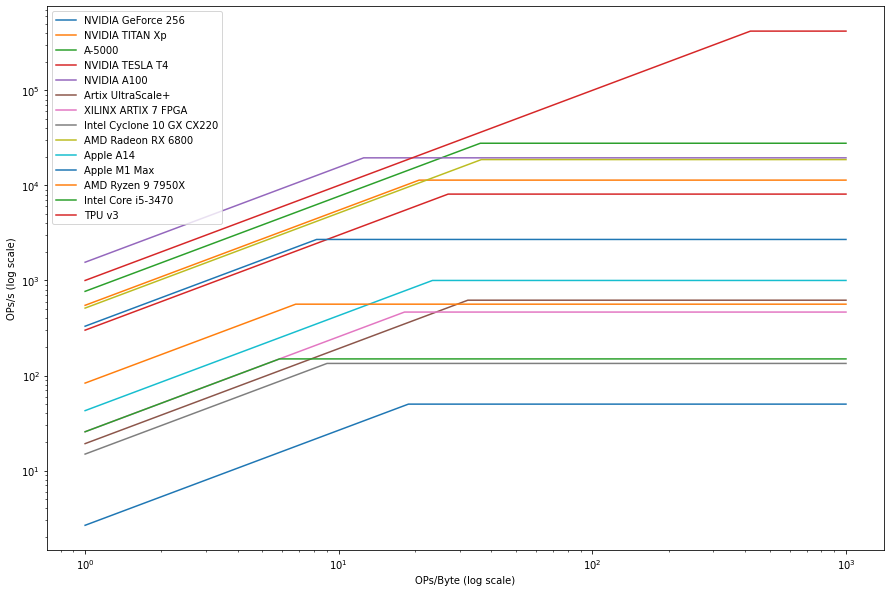

In [22]:
#Roofline plot for all chip types
plot_roofline(mix_chips)

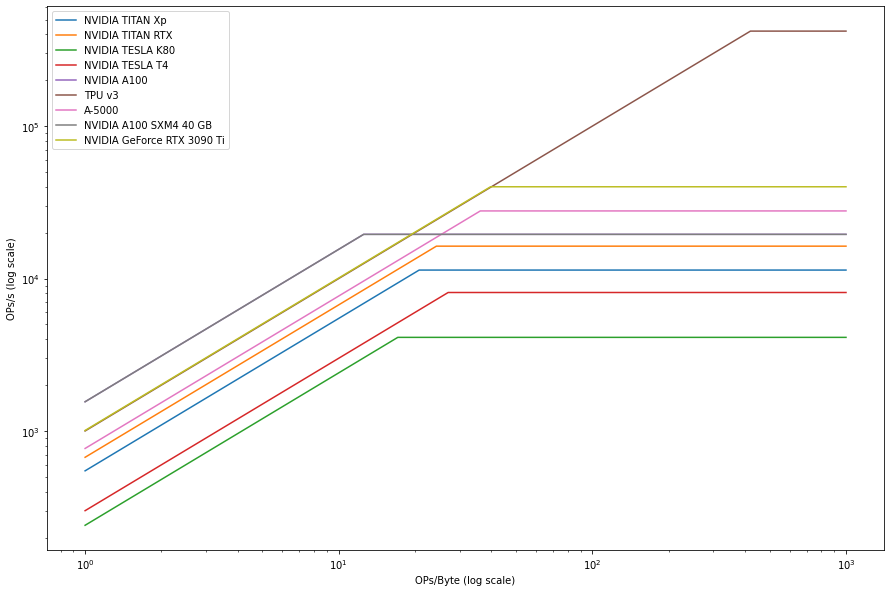

In [24]:
#Roofline plot for gpu chips
plot_roofline(gpu_chips)

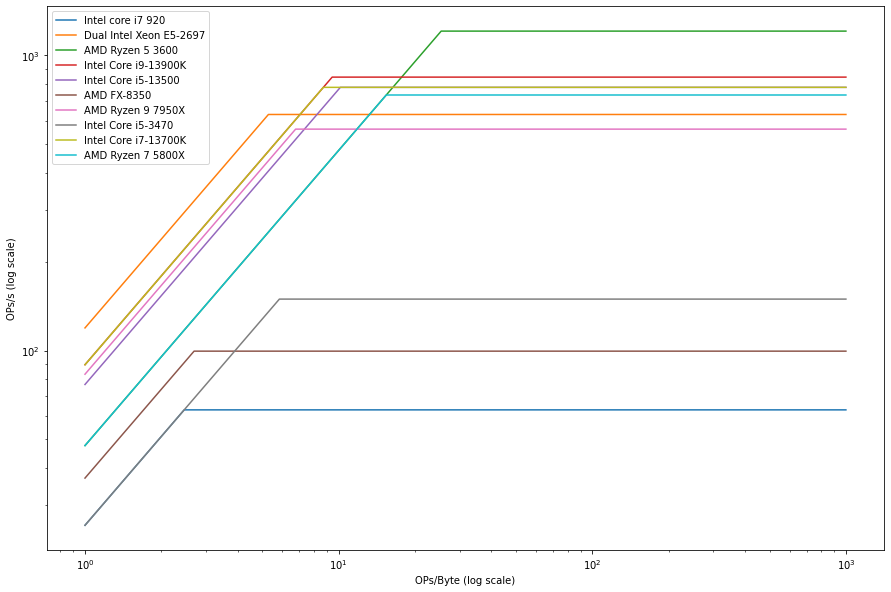

In [23]:
#Roofline plot for cpu chips
plot_roofline(cpu_chips)

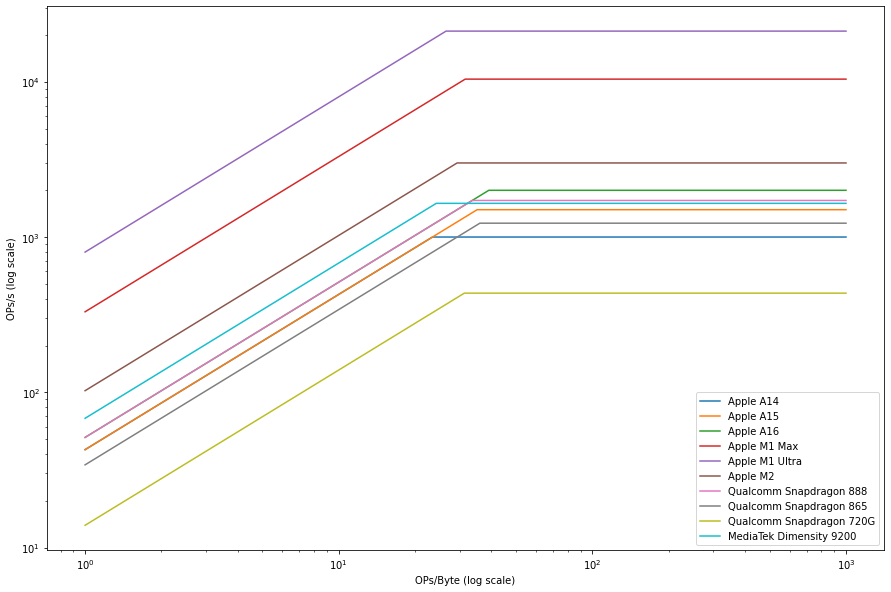

In [25]:
#Roofline plot for soc chips
plot_roofline(soc_chips)

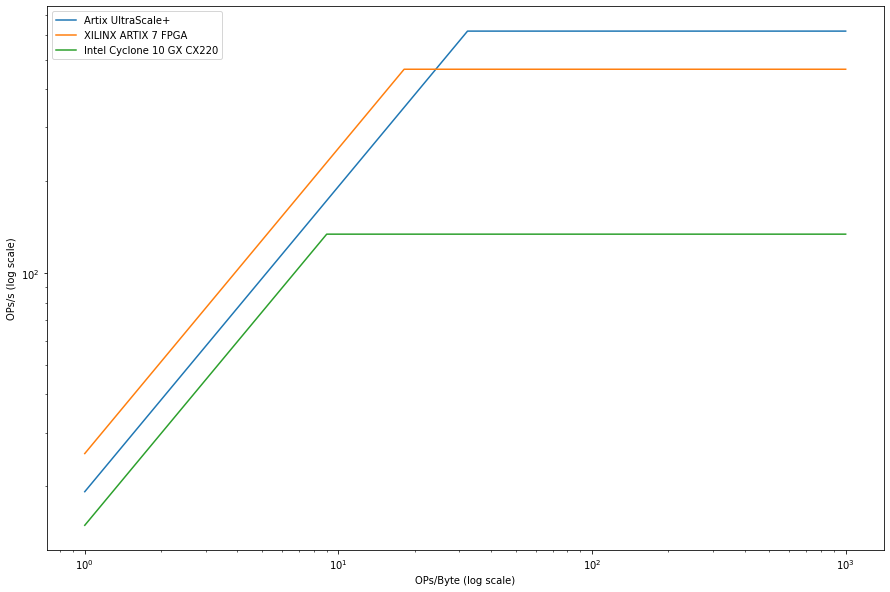

In [26]:
#Roofline plot for fpga chips
plot_roofline(fpga_chips)

## Part Two: DNN Compute and Memory Analysis
<ul type= "circle">
<li>Pick at least 10 different DNNs to analyze. You may use torchvision, torchaudio, pytorchcv or any available model definitions.</li>
<li> Find the number of FLOPs and memory footprint of each model and calculate the operational intensity. Note that you may use any PyTorch-compatible libraries to compute these values (for example thop, torchsummary, ptflops or others. Visualize the results using bar charts or other chart types as you see fit. The idea is to visually compare the models in an easy way.</li>
<li> Overlay the operational intensity on the roofline plots of the CPU and GPU that you have access to on Colab.</li>
<li> Comment on which workloads are memory/compute bound on different hardware targets.</li>
</ul>
https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

In [80]:
# Define the preprocessing transform
def get_transform():
    """
    Returns a torchvision transform to preprocess an input image.
    """
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform

# model_info function to load the pre-trained model, preprocess the input image, and evaluate the model
def model_info(model_name):
    """
    Loads a pre-trained model specified by `model_name`, preprocesses an input image, and evaluates the model.
    """
    # Load the pre-trained model
    model_func = getattr(models, model_name)
    model = model_func(pretrained=True)


    # Move the model to the same device as the input data
    model = model.to(torch.device('cpu'))
    
    # Preprocess the input image
    transform = get_transform()
    img = Image.fromarray(np.random.randint(256, size=(265, 265, 3)).astype(np.uint8))
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0).to(torch.device('cpu'))

    # Evaluate the model
    with torch.no_grad():
        model.eval()
    input = torch.randn(1, 3, 224, 224)
    macs, params = profile(model, inputs=(input,), verbose=False)

    # Print the model summary and GFLOPS
    model = model.to(torch.device('cpu'))
    summary(model, (3, 224, 224))
    print('The GFLOPS for the model are: ' + str((macs / 1e9) * 2))


model_info('resnet50')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

Note, after running the code above for the various models, we record the Estimated Total Size (MB) and the GFLOPS manually in a new dictionary. While this is not the most efficient way to do this, it suffices for this exercise. 

In [5]:
"""
Creates a dictionary for the models with the following scheme 

dict = { 'model_name', {'GF': , 'MB': }}
"""
model_dict = {
    'googlenet': {'GF': 3.02, 'MB': 119.95}, 
    'mobilenet_v3_large': {'GF':0.47 , 'MB': 126.90}, 
    'resnet18': {'GF': 3.65, 'MB': 107.96}, 
    'vgg11': {'GF': 15.2, 'MB':632.78 }, 
    'resnet50': {'GF': 8.22, 'MB': 384.62},
    'alexnet': {'GF': 1.43, 'MB': 242.03},
    'mobilenet_v3': {'GF': 0.45, 'MB': 126.9},
    'vgg19': {'GF': 39.29, 'MB': 787.31},
    'squeezenet1_0': {'GF': 1.65, 'MB': 97.14},
    'efficientnet_b7': {'GF': 10.53, 'MB': 1330},
    'googlenet': {'GF': 3.01, 'MB': 119.950},
    'shufflenet': {'GF': 0.09, 'MB': 30.85},
    'wideresnet101_2': {'GF': 45.59, 'MB': 1030},
    'inception_v3': {'GF': 5.69, 'MB': 209.48}
}

In [6]:
#Add in operational intensity 
def add_oi(input_dict):
    """
    Calculates the oi value (GF / MF * 1000) for each model in the input_dict
    and adds it to the corresponding dictionary as the 'oi' key-value pair.

    Args:
        input_dict (dict): A dictionary containing model names as keys and a dictionary of
            'GF' (float) and 'MF' (float) values as values.

    Returns:
        dict: A dictionary with the same structure as input_dict, but with the addition of
            the 'oi' key-value pair for each model.

    """
    for model in input_dict:
        gf = input_dict[model]['GF']
        mf = input_dict[model]['MB']
        oi = gf / mf * 1000
        input_dict[model]['oi'] = oi
    return input_dict


In [7]:
#Applies operational intenisty to the mdoel dictionary 
add_oi(model_dict)

{'googlenet': {'GF': 3.01, 'MB': 119.95, 'oi': 25.093789078782823},
 'mobilenet_v3_large': {'GF': 0.47, 'MB': 126.9, 'oi': 3.7037037037037033},
 'resnet18': {'GF': 3.65, 'MB': 107.96, 'oi': 33.808818080770656},
 'vgg11': {'GF': 15.2, 'MB': 632.78, 'oi': 24.02098675685072},
 'resnet50': {'GF': 8.22, 'MB': 384.62, 'oi': 21.37174353907753},
 'alexnet': {'GF': 1.43, 'MB': 242.03, 'oi': 5.908358467958517},
 'mobilenet_v3': {'GF': 0.45, 'MB': 126.9, 'oi': 3.5460992907801416},
 'vgg19': {'GF': 39.29, 'MB': 787.31, 'oi': 49.90410384727744},
 'squeezenet1_0': {'GF': 1.65, 'MB': 97.14, 'oi': 16.9857936998147},
 'efficientnet_b7': {'GF': 10.53, 'MB': 1330, 'oi': 7.917293233082707},
 'shufflenet': {'GF': 0.09, 'MB': 30.85, 'oi': 2.917341977309562},
 'wideresnet101_2': {'GF': 45.59, 'MB': 1030, 'oi': 44.2621359223301},
 'inception_v3': {'GF': 5.69, 'MB': 209.48, 'oi': 27.162497613137294}}

In [43]:
#Plots a bar chart of operational intensity 
def plot_oi(input_dict):
    """
    Plot a bar graph of 'oi' values in the given dictionary.

    Args:
    input_dict (dict): A dictionary where the keys are the x-axis labels and 
                       the values are dictionaries containing the 'oi' values.
    """
    x_labels = list(input_dict.keys())
    oi_values = [input_dict[i]['oi'] for i in x_labels]

    # Sort bars in descending order
    sorted_indices = sorted(range(len(oi_values)), key=lambda k: oi_values[k], reverse=True)
    sorted_labels = [x_labels[i] for i in sorted_indices]
    sorted_values = [oi_values[i] for i in sorted_indices]

    # Assign a unique color to each bar
    colors = plt.cm.tab20.colors[:len(x_labels)]

    # Plot bar graph
    plt.bar(sorted_labels, sorted_values, color=colors)
    plt.xticks(rotation=66)
    plt.show()

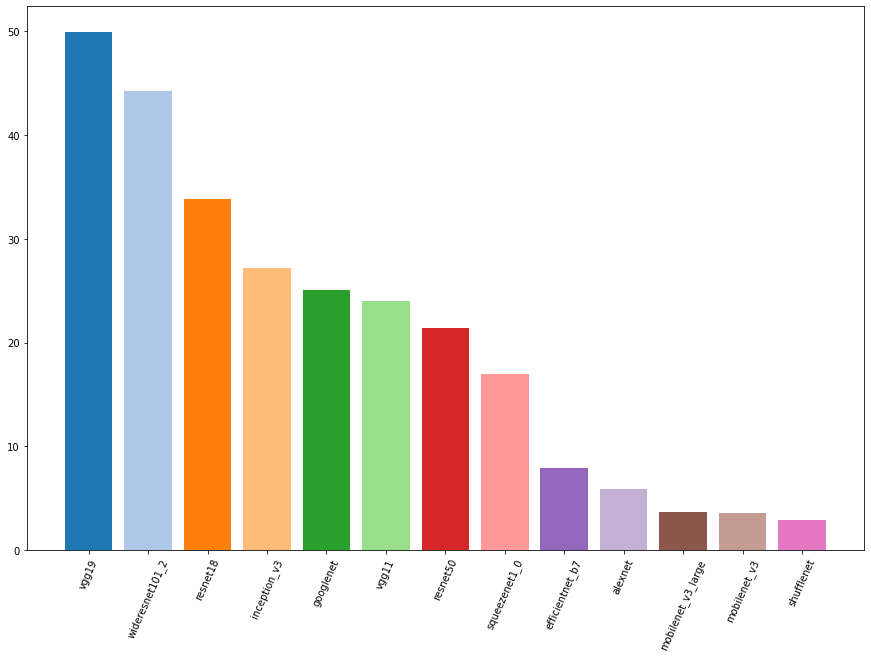

In [44]:
#Applies the bar_oi function to the model dictionary 
plot_oi(model_dict)

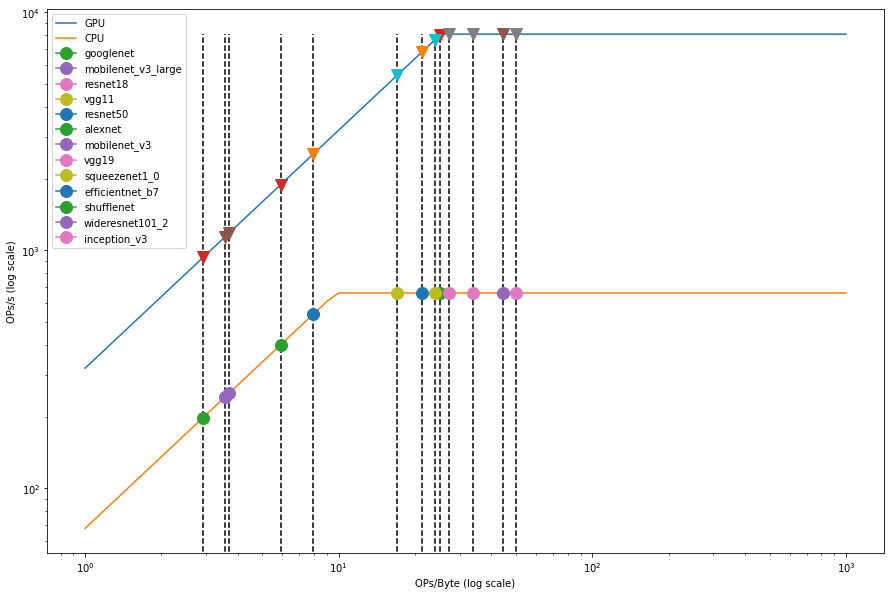

In [48]:
def plot_model_roofline(model_dict):
    """
    Plots the theoretical and peak performance of a model onto the roofline of Google Colab's CPU and GPU
    using the operational intensity (oi) and computational performance (GFLOPs) of the model, as well as the 
    memory bandwidth (MF) of the device.

    Args:
        model_dict (dict): A dictionary containing the GFLOPs, MF, and oi for each model to be plotted.

    Returns:
        None
    """

    # Device specifications for Google Colab's CPU and GPU
    gpu_peak_gflops = 8100
    gpu_memory_bandwidth = 320
    cpu_peak_gflops = 662.4
    cpu_memory_bandwidth = 68

    # Plot the rooflines for CPU and GPU
    x = np.linspace(1, 1000, num=1000)
    fig, ax = plt.subplots()
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(x, [min(gpu_memory_bandwidth*x, gpu_peak_gflops) for x in x], label='GPU')
    plt.plot(x, [min(cpu_memory_bandwidth*x, cpu_peak_gflops) for x in x], label='CPU')

    # Plot each model on the roofline
    for model_name, model_info in model_dict.items():
        oi = model_info['oi']
        gflops = model_info['GF']
        memory_bandwidth = model_info['MB']

        # Calculate the maximum performance for CPU and GPU given the model's operational intensity
        cpu_max_performance = min(cpu_memory_bandwidth * oi, cpu_peak_gflops)
        gpu_max_performance = min(gpu_memory_bandwidth * oi, gpu_peak_gflops)

        # Plot the model's maximum performance point for CPU and GPU
        plt.plot(oi, cpu_max_performance,  marker="o", markersize=12, label=model_name)
        plt.plot(oi, gpu_max_performance,  marker="v", markersize=12)

        # Plot a vertical line to show the operational intensity for the model
        plt.vlines(x=oi, ymin=0, ymax=gpu_peak_gflops, ls='--')

    # Add a legend and axis labels to the plot
    plt.legend(loc='best')
    plt.ylabel("OPs/s (log scale)")
    plt.xlabel("OPs/Byte (log scale)")
    plt.show()


plot_model_roofline(model_dict)

## Part Three: DNN Performance Benchmarking

<ul type= "circle">
<li>Plot the inference latency (at batch sizes = {1,64,256}) vs. FLOPs of each model from part 2 on both the CPU and GPU that you have access to on Colab. You may find it useful to color the points on the plot based on batch size and perhaps label the points on the plot with the model name. It is important to produce an easily-readable plot.</li>
<li> Repeat the point above but put parameters on the x-axis instead of FLOPs.</li>
<li> Compute the rank correlation coefficient between (1) CPU latency, (2) GPU latency, (3) FLOPs and (4) parameters. Visualize this as a 2D matrix of correlation values. You may use either Spearman's or other rank correlation coefficients. </li>
<li> Comment on whether FLOPs or parameters are a good estimate of how fast the model runs. Explain, with examples, why FLOPs/parameters could in some cases be an accurate indicator of latency, and why in other cases it isn't.</li>
<li>Plot the throughput of your DNNs on CPU/GPU at different batch sizes.</li>
</ul>

In [13]:
import time
import torch
from torchvision import models
from thop import profile

def run_model(model_name):
    """
    Run a specified model and record performance metrics.

    Args:
    - model_name (str): Name of the model to run.

    Returns:
    - dict: A dictionary containing performance metrics for the specified model.
    """
    # Check that the input model name exists in the `models` module
    if not hasattr(models, model_name):
        raise ValueError(f"Invalid model name '{model_name}'. Must be a valid model name in the `models` module.")

    # Dictionary to store model results
    model_dict = {}

    # Evaluate the specified model on CPU and GPU
    model = getattr(models, model_name)(weights=True)
    for device_name in ['cpu', 'cuda']:
        model_dict[device_name] = {}

        # Evaluate on specified device
        device = torch.device(device_name)
        model.to(device)
        model.eval()
        for batch_size in   [1, 64]: #,  [256]: #
            # Generate random input tensor
            batch_t = torch.rand(size=(batch_size, 3, 112, 112)).to(device)

            # Evaluate model and record results
            start = time.time()
            out = model(batch_t)
            end = time.time()
            

            # Record model complexity metrics
            macs, params = profile(model, inputs=(batch_t,), verbose=False)
            model_dict[device_name]['batch_' + str(batch_size) + '_flops'] = 2 * macs
            model_dict[device_name]['batch_' + str(batch_size) + '_params'] = params
            model_dict[device_name]['batch_' + str(batch_size) + '_time'] = end - start

        # Record results for current device
        model_dict[device_name]['flops'] = 2 * macs
        model_dict[device_name]['params'] = params

    # Print final results for the specified model
    print(model_dict)
    return model_dict


In [14]:
#Calls the function 
run_model('alexnet')

{'cpu': {'batch_1_flops': 408914304.0, 'batch_1_params': 61100840.0, 'batch_1_time': 0.02824568748474121, 'batch_64_flops': 26170515456.0, 'batch_64_params': 61100840.0, 'batch_64_time': 0.5373721122741699, 'flops': 26170515456.0, 'params': 61100840.0}, 'cuda': {'batch_1_flops': 408914304.0, 'batch_1_params': 61100840.0, 'batch_1_time': 0.009727716445922852, 'batch_64_flops': 26170515456.0, 'batch_64_params': 61100840.0, 'batch_64_time': 0.002396821975708008, 'flops': 26170515456.0, 'params': 61100840.0}}


{'cpu': {'batch_1_flops': 408914304.0,
  'batch_1_params': 61100840.0,
  'batch_1_time': 0.02824568748474121,
  'batch_64_flops': 26170515456.0,
  'batch_64_params': 61100840.0,
  'batch_64_time': 0.5373721122741699,
  'flops': 26170515456.0,
  'params': 61100840.0},
 'cuda': {'batch_1_flops': 408914304.0,
  'batch_1_params': 61100840.0,
  'batch_1_time': 0.009727716445922852,
  'batch_64_flops': 26170515456.0,
  'batch_64_params': 61100840.0,
  'batch_64_time': 0.002396821975708008,
  'flops': 26170515456.0,
  'params': 61100840.0}}

Much like with the previous part, we run the code multiple times and manually add teh results to the dictionary. Unlike the previous time,we ran into RAM issues here so it was broken up into batches 1,64 and 256. This is an area for improvement as this process was slow and the function I wrote maxxed out RAM for several of the models.

In [4]:
#Manual add for CPU and GPU 
batch_model ={
  'alexnet': {'GF': 1.43, 'MB': 242.03, 
  'cpu': {'batch_1_flops': 408914304.0,
          'batch_1_params': 61100840.0,
          'batch_1_time': 0.13910126686096191,
          'batch_64_flops': 26170515456.0,
          'batch_64_params': 61100840.0,
          'batch_64_time': 0.5528178215026855,
          'batch_256_flops': 104682061824.0,
          'batch_256_params': 61100840.0,
          'batch_256_time': 2.6597251892089844},           
  'cuda': {'batch_1_flops': 408914304.0,
          'batch_1_params': 61100840.0,
          'batch_1_time': 0.011379480361938477,
          'batch_64_flops': 26170515456.0,
          'batch_64_params': 61100840.0,
          'batch_64_time': 0.022037744522094727,
          'batch_256_flops': 104682061824.0,
          'batch_256_params': 61100840.0,
          'batch_256_time': 0.0032219886779785156},
  'oi': 5.908358467958517},
  'shufflenet': {'GF': 0.09,'MB': 30.85,
  'cpu': {'batch_1_flops': 24892128.0,
          'batch_1_params': 1366792.0,
          'batch_1_time': 0.014089822769165039,
          'batch_64_flops': 1593096192.0,
          'batch_64_params': 1366792.0,
          'batch_64_time': 0.13978195190429688},
  'cuda': {'batch_1_flops': 24892128.0,
          'batch_1_params': 1366792.0,
          'batch_1_time': 0.011913299560546875,
          'batch_64_flops': 1593096192.0,
          'batch_64_params': 1366792.0,
          'batch_64_time': 0.009972810745239258},
  'oi': 2.917341977309562},
  'wideresnet101_2': {'GF': 1.65,'MB': 97.14,
  'cpu': {'batch_1_flops': 11707799552.0,
          'batch_1_params': 126886696.0,
          'batch_1_time': 0.5459306240081787,
          'batch_64_flops': 749299171328.0,
          'batch_64_params': 126886696.0,
          'batch_64_time': 13.23681378364563},
  'cuda': {'batch_1_flops': 11707799552.0,
          'batch_1_params': 126886696.0,
          'batch_1_time': 0.02516627311706543,
          'batch_64_flops': 749299171328.0,
          'batch_64_params': 126886696.0,
          'batch_64_time': 0.05903339385986328},
  'oi': 16.9857936998147},
  'inception_v3': {'GF': 5.69, 'MB': 209.48, 
  'cpu': {'batch_1_flops': 1084523072.0,
          'batch_1_params': 23834568.0,
          'batch_1_time': 0.13658428192138672,
          'batch_64_flops': 69409476608.0,
          'batch_64_params': 23834568.0,
          'batch_64_time': 1.9373373985290527,
          'batch_256_flops': 277637906432.0,
          'batch_256_params': 23834568.0,
          'batch_256_time': 8.43899416923523},
  'cuda': {'batch_1_flops': 1084523072.0,
          'batch_1_params': 23834568.0,
          'batch_1_time': 6.073119163513184,
          'batch_64_flops': 69409476608.0,
          'batch_64_params': 23834568.0,
          'batch_64_time': 0.047777652740478516,
          'batch_256_flops': 277637906432.0,
          'batch_256_params': 23834568.0,
          'batch_256_time': 0.10109710693359375},
  'oi': 27.162497613137294},
  'mobilenet_v3': {'GF': 0.45,'MB': 126.9,
  'cpu': {'batch_1_flops': 126229424.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.033350467681884766,
          'batch_256_flops': 32314732544.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 3.3069205284118652,
          'batch_64_flops': 8078683136.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.5233912467956543},
  'cuda': {'batch_1_flops': 126229424.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.04151201248168945,
          'batch_256_flops': 32314732544.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 0.03913736343383789,
          'batch_64_flops': 8078683136.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.01717090606689453},
  'oi': 3.5460992907801416},
  'efficientnet_b7': {'GF': 10.53,'MB': 1330,
  'cpu': {'batch_1_flops': 2967297184.0,
          'batch_1_params': 66347960.0,
          'batch_1_time': 0.4362795352935791,
          'batch_64_flops': 189907019776.0,
          'batch_64_params': 66347960.0,
          'batch_64_time': 18.582102060317993},
  'cuda': {'batch_1_flops': 2967297184.0,
          'batch_1_params': 66347960.0,
          'batch_1_time': 0.3726234436035156,
          'batch_64_flops': 189907019776.0,
          'batch_64_params': 66347960.0,
          'batch_64_time': 0.1457521915435791},
  'oi': 7.917293233082707},
  'squeezenet1_0': {'GF': 1.65, 'MB': 97.14,
  'cpu': {'batch_1_flops': 376806736.0,
          'batch_1_params': 1248424.0,
          'batch_1_time': 0.04456162452697754,
          'batch_64_flops': 24115631104.0,
          'batch_64_params': 1248424.0,
          'batch_64_time': 0.7951359748840332,
          'batch_256_flops': 96462524416.0,
          'batch_256_params': 1248424.0,
          'batch_256_time': 4.062472581863403},
  'cuda': {'batch_1_flops': 376806736.0,
          'batch_1_params': 1248424.0,
          'batch_1_time': 0.0404362678527832,
          'batch_64_flops': 24115631104.0,
          'batch_64_params': 1248424.0,
          'batch_64_time': 0.014661550521850586,
          'batch_256_flops': 96462524416.0,
          'batch_256_params': 1248424.0,
          'batch_256_time': 0.06029772758483887},
  'oi': 16.9857936998147},
  'vgg19': {'GF': 39.29, 'MB': 787.31, 
  'cpu': {'batch_1_flops': 10001541120.0,
          'batch_1_params': 143667240.0,
          'batch_1_time': 0.22405195236206055,
          'batch_64_flops': 640098631680.0,
          'batch_64_params': 143667240.0,
          'batch_64_time': 12.35991382598877,
          'batch_256_flops': 2560394526720.0,
          'batch_256_params': 143667240.0,
          'batch_256_time': 53.55769371986389},
  'cuda': {'batch_1_flops': 10001541120.0,
          'batch_1_params': 143667240.0,
          'batch_1_time': 0.027074813842773438,
          'batch_64_flops': 640098631680.0,
          'batch_64_params': 143667240.0,
          'batch_64_time': 0.003940105438232422,
          'batch_256_flops': 2560394526720.0,
          'batch_256_params': 143667240.0,
          'batch_256_time': 0.48122596740722656},
  'oi': 49.90410384727744},
  'googlenet': {'GF': 3.01, 'MB': 119.95,
  'cpu': {'batch_1_flops': 774690432.0,
          'batch_1_params': 6624904.0,
          'batch_1_time': 0.061057090759277344,
          'batch_64_flops': 49580187648.0,
          'batch_64_params': 6624904.0,
          'batch_64_time': 3.9398393630981445,
          'batch_256_flops': 198320750592.0,
          'batch_256_params': 6624904.0,
          'batch_256_time': 7.438979387283325},
 'cuda': {'batch_1_flops': 774690432.0,
         'batch_1_params': 6624904.0,
         'batch_1_time': 0.04703545570373535,
         'batch_64_flops': 49580187648.0,
         'batch_64_params': 6624904.0,
         'batch_64_time': 0.025586605072021484,
         'batch_256_flops': 198320750592.0,
         'batch_256_params': 6624904.0,
         'batch_256_time': 0.1215727329254150},
  'oi': 25.093789078782823},
  'mobilenet_v3_large': {'GF': 0.47, 'MB': 126.9,
  'cpu': {'batch_1_flops': 130708352.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.05689859390258789,
          'batch_64_flops': 8365334528.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.5098750591278076,
          'batch_256_flops': 33461338112.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 3.123216390609741},
  'cuda': {'batch_1_flops': 130708352.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.03197765350341797,
          'batch_64_flops': 8365334528.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.0245530605316162,
          'batch_256_flops': 33461338112.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 0.09846353530883789},                                 
  'oi': 3.7037037037037033},
  'resnet18': {'GF': 3.65, 'MB': 107.96, 
  'cpu': {'batch_1_flops': 975780864.0,
          'batch_1_params': 11689512.0,
          'batch_1_time': 0.04091501235961914,
          'batch_64_flops': 62449975296.0,
          'batch_64_params': 11689512.0,
          'batch_64_time': 1.2949855327606201,
          'batch_256_flops': 249799901184.0,
          'batch_256_params': 11689512.0,
          'batch_256_time': 5.764563798904419},
  'cuda': {'batch_1_flops': 975780864.0,
          'batch_1_params': 11689512.0,
          'batch_1_time': 0.005395412445068359,
          'batch_64_flops': 62449975296.0,
          'batch_64_params': 11689512.0,
          'batch_64_time': 0.0053217411041259766,
          'batch_256_flops': 249799901184.0,
          'batch_256_params': 11689512.0,
          'batch_256_time': 0.02161431312561035},
  'oi': 33.808818080770656},
  'vgg11': {'GF': 15.2, 'MB': 632.78, 
  'cpu': {'batch_1_flops': 3990054912.0,
          'batch_1_params': 132863336.0,
          'batch_1_time': 0.11728382110595703,
          'batch_64_flops': 255363514368.0,
          'batch_64_params': 132863336.0,
          'batch_64_time': 5.5948710441589355,
          'batch_256_flops': 1021454057472.0,
          'batch_256_params': 132863336.0,
          'batch_256_time': 22.470963716506958},
  'cuda': {'batch_1_flops': 3990054912.0,
          'batch_1_params': 132863336.0,
          'batch_1_time': 0.024320363998413086,
          'batch_64_flops': 255363514368.0,
          'batch_64_params': 132863336.0,
          'batch_64_time': 0.0034601688385009766,
          'batch_256_flops': 1021454057472.0,
          'batch_256_params': 132863336.0,
          'batch_256_time': 0.22866177558898926},
  'oi': 24.02098675685072},
  'resnet50': {'GF': 8.22, 'MB': 384.62, 
  'cpu': {'batch_1_flops': 2178418688.0,
          'batch_1_params': 25557032.0,
          'batch_1_time': 0.0712122917175293,
          'batch_64_flops': 139418796032.0,
          'batch_64_params': 25557032.0,
          'batch_64_time': 3.6122326850891113,
          'batch_256_flops': 557675184128.0,
          'batch_256_params': 25557032.0,
          'batch_256_time': 21.036190509796143},
  'cuda': {'batch_1_flops': 2178418688.0,
          'batch_1_params': 25557032.0,
          'batch_1_time': 0.0246732234954834,
          'batch_64_flops': 139418796032.0,
          'batch_64_params': 25557032.0,
          'batch_64_time': 0.01570725440979004,
          'batch_256_flops': 557675184128.0,
          'batch_256_params': 25557032.0,
          'batch_256_time': 0.31880640983581543},
  'oi': 21.37174353907753}}

In [5]:
# Define the legend dictionary for colors and shapes
legend_dict = {
    'color': {'cpu': '#1f77b4', 'cuda': '#ff7f0e'},
    'shape': {1: 'o', 64: 's', 256: 'H'}
}

# Define a function to plot the flops benchmark
def flops_benchmark(input_dictionary):
    """
    Plot the flops benchmark for the given input dictionary.

    Args:
    - input_dictionary: A dictionary of model benchmarks on CPU and GPU devices.

    Returns:
    - None
    """
    # Set the x-axis as flops
    x_axis = 'flops'

    # Iterate over the models and devices in the input dictionary
    for model in input_dictionary.keys():
        for device in ['cpu', 'cuda']:
            # Iterate over the keys in the current device dictionary
            for key in input_dictionary[model][device].keys():
                # Check if the key represents time
                if '_time' in key:
                    # Get the current batch size and time values
                    current_batch_size = int(key.split('_')[1])
                    y = input_dictionary[model][device][key]
                    x = input_dictionary[model][device]['batch_' + str(current_batch_size) + '_' + x_axis]
                    # Plot the point on the scatter plot
                    plt.scatter([x], [y], marker=legend_dict['shape'][current_batch_size], c=legend_dict['color'][device])

    # Set the y-axis and x-axis scales to logarithmic
    plt.yscale('log')
    plt.xscale('log')

    # Set the x-axis and y-axis labels
    plt.xlabel('FLOPs' )
    plt.ylabel('Time (in seconds)')

    #Display Legend
    plt.legend()

    # Display the scatter plot
    plt.show()


In [6]:
def flops_benchmark_2(input_dictionary):
    """
    Plot the flops benchmark for the given input dictionary.

    Args:
    - input_dictionary: A dictionary of model benchmarks on CPU and GPU devices.

    Returns:
    - None
    """
    # Set the x-axis as flops
    x_axis = 'flops'

    # Iterate over the models and devices in the input dictionary
    for model in input_dictionary.keys():
        for device in ['cpu', 'cuda']:
            # Iterate over the keys in the current device dictionary
            for key in input_dictionary[model][device].keys():
                # Check if the key represents time
                if '_time' in key:
                    # Get the current batch size and time values
                    current_batch_size = int(key.split('_')[1])
                    y = input_dictionary[model][device][key]
                    x = input_dictionary[model][device]['batch_' + str(current_batch_size) + '_' + x_axis]
                    # Plot the point on the scatter plot with label and model name
                    plt.scatter([x], [y], marker=legend_dict['shape'][current_batch_size], c=legend_dict['color'][device], label=model, alpha=0.7)
                    plt.text(x, y, model, ha='left', va='center') # add model name as text label

    # Set the y-axis and x-axis scales to logarithmic
    plt.yscale('log')
    plt.xscale('log')

    # Set the x-axis and y-axis labels
    plt.xlabel('FLOPs')
    plt.ylabel('Time (in seconds)')

    # Display Legend
    #plt.legend()

    # Display the scatter plot
    plt.show()


In [7]:
def plot_param_benchmark(input_dict):
    """
    Plots a scatter plot of time taken by different models and devices with respect to their parameters.
    
    Args:
        input_dict (dict): A dictionary containing the model names and their respective 
                           devices and parameters with their time taken as value.
    """
    x_axis = 'params'
    
    # Loop over the input dictionary to plot the graph
    for model_name, model_values in input_dict.items():
        for device in ['cpu', 'cuda']:
            for key in model_values[device].keys():
                if '_time' in key:
                    current_batch_size = int(key.split('_')[1])
                    y =  model_values[device][key]
                    x =  model_values[device]['batch_{}_{}'.format(current_batch_size, x_axis)]
                    # legend_dict not defined in the given code, it should be defined before calling the function.
                    plt.scatter([x], [y], marker=legend_dict['shape'][current_batch_size], c=legend_dict['color'][device])
                    
    # set the axes scale to log
    plt.yscale('log')
    plt.xscale('log')
    
    # set the axis labels
    plt.xlabel('Parameters')
    plt.ylabel('Time (in seconds)')
    
    #Display Legend
    plt.legend()

    # display the plot
    plt.show()


In [19]:
def plot_param_benchmark_2(input_dict):
    """
    Plots a scatter plot of time taken by different models and devices with respect to their parameters.
    
    Args:
        input_dict (dict): A dictionary containing the model names and their respective 
                           devices and parameters with their time taken as value.
    """
    x_axis = 'params'
    
    # Iterate over the models and devices in the input dictionary
    for model in input_dict.keys():
        for device in ['cpu', 'cuda']:
            # Iterate over the keys in the current device dictionary
            for key in input_dict[model][device].keys():
                # Check if the key represents time
                if '_time' in key:
                    # Get the current batch size and time values
                    current_batch_size = int(key.split('_')[1])
                    y = input_dict[model][device][key]
                    x = input_dict[model][device]['batch_' + str(current_batch_size) + '_' + x_axis]
                    # Plot the point on the scatter plot with label and model name
                    plt.scatter([x], [y], marker=legend_dict['shape'][current_batch_size], c=legend_dict['color'][device], label=model, alpha=0.7)
                    plt.text(x, y, model, ha='left', va='center') # add model name as text label

    # Set the y-axis and x-axis scales to logarithmic
    plt.yscale('log')
    plt.xscale('log')

    # Set the x-axis and y-axis labels
    plt.xlabel('FLOPs')
    plt.ylabel('Time (in seconds)')


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Spearman correlation plotting function 
def get_spearman(input_dictionary, batch_size):
    """"
    Plots the Spearman correlation heatmap for the given batch_model.

    Args:
    input_dictionary: A dictionary containing performance metrics for different
                      models on CPU and GPU for different batch sizes.
    batch_size: A batch size (1, 64, or 256) for which to generate the Spearman
                correlation heatmap.
    """
    # Create an empty dictionary to store the data
    df_dict = {'CPU Latency': [], 'GPU Latency': [], 'FLOPs': [], 'Parameters': []}

    # Iterate through the input dictionary and extract the performance metrics for the given batch size
    for model in input_dictionary.keys():
        for key in input_dictionary[model]['cpu'].keys():
            if f'batch_{batch_size}' in key:
                if key.endswith('_time'):
                    df_dict['CPU Latency'].append(input_dictionary[model]['cpu'][key])
                    df_dict['GPU Latency'].append(input_dictionary[model]['cuda'][key])
                elif key.endswith('_flops'):
                    df_dict['FLOPs'].append(input_dictionary[model]['cpu'][key])
                elif key.endswith('_params'):
                    df_dict['Parameters'].append(input_dictionary[model]['cpu'][key])

    # Convert the dictionary to a pandas DataFrame and calculate the Spearman correlation
    df = pd.DataFrame.from_dict(df_dict)
    spearman = df.corr(method='spearman')

    # Plot the heatmap using seaborn
    plt.figure(figsize=(10, 6), dpi=200)
    heatmap = sns.heatmap(spearman, vmin=-1, vmax=1, annot=True)
    plt.title(f"Spearman Correlation for Batch Size {batch_size}")
    plt.show()


In [10]:
def plot_spearman_correlation(input_dictionary):
    """
    Plots the Spearman correlation between CPU latency, GPU latency, FLOPs, and parameters for the models in the input dictionary.
    
    Args:
    input_dictionary (dict): A dictionary containing performance metrics for different models on CPU and GPU.
    
    Returns:
    None
    """
    # Extract CPU latency, FLOPs, GPU latency, and parameters from input dictionary
    cpu_latencies = []
    flops = []
    gpu_latencies = []
    parameters = []
    for model in input_dictionary.keys():
        for key in input_dictionary[model]['cpu'].keys():
            if '_time' in key:
                cpu_latencies.append(input_dictionary[model]['cpu'][key])
                flops.append(input_dictionary[model]['cpu'][key[:-4] + 'flops'])
                gpu_latencies.append(input_dictionary[model]['cuda'][key])
                parameters.append(input_dictionary[model]['cpu'][key[:-4] + 'params'])
    
    # Create a dataframe from the extracted metrics and compute the Spearman correlation
    df = pd.DataFrame({'CPU Latency': cpu_latencies, 'GPU Latency': gpu_latencies, 'FLOPs': flops, 'Parameters': parameters})
    spearman_corr = df.corr(method='spearman')
    
    # Plot the Spearman correlation heatmap
    plt.figure(figsize=(10,6), dpi=200)
    sns.heatmap(spearman_corr, vmin=-1, vmax=1, annot=True)
    plt.title('Spearman Correlation')
    plt.show()


In [11]:
def plot_throughput(input_dictionary):
    """
    Plots throughput for each batch size for each model and device
    :param input_dictionary: a dictionary containing data for each model and device
    """
    # Loop through each model and device
    for model, model_data in input_dictionary.items():
        for device in ['cpu', 'cuda']:
            device_data = model_data.get(device, {})
            for key, value in device_data.items():
                # Check if the key is a batch size time measurement
                if '_time' in key:
                    current_batch_size = int(key.split('_')[1])
                    x = current_batch_size
                    y = current_batch_size / value
                    plt.scatter([x], [y], c=legend_dict['color'][device])

    # Set the axis scales and labels, and show the plot
    plt.yscale('log')
    plt.xscale('linear')
    plt.xlabel('Batch Size')
    plt.ylabel('Throughput (log scale)')
    plt.show()

In [12]:
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten(v, new_key, sep=sep))
        else:
            items.append((new_key, v))
    return items

#Defines the throughout plotting function 
def plot_throughput_bar(batch_model):
    # Initialize lists for plotting
    x_cpu = []
    x_cuda = []
    y_cpu = []
    y_cuda = []

    # Loop through each model and device combination
    for model, model_dict in batch_model.items():
        for device, device_dict in model_dict.items():
            # Skip if the key is GF or MB
            if device in ['GF', 'MB']:
                continue
            # Initialize lists for each device
            x = []
            y = []
            # Loop through the batch sizes
            for key, val in device_dict.items():
                if '_time' in key:
                    current_batch_size = int(key.split('_')[1])
                    x.append(current_batch_size)
                    y.append(current_batch_size / val)
            # Add to the appropriate list
            if device == 'cpu':
                x_cpu.append(x)
                y_cpu.append(y)
            else:
                x_cuda.append(x)
                y_cuda.append(y)

    # Create the bar chart
    bar_width = 0.35
    opacity = 0.8
    n_groups = len(x_cpu[0])
    index = np.arange(n_groups)

    fig, ax = plt.subplots()
    rects1 = ax.bar(index, y_cpu[0], bar_width, alpha=opacity, color='b', label='cpu')
    rects2 = ax.bar(index + bar_width, y_cuda[0], bar_width, alpha=opacity, color='g', label='cuda')

    for i in range(1, len(x_cpu)):
        rects1 = ax.bar(index + (i * bar_width), y_cpu[i], bar_width, alpha=opacity, color='b')
        rects2 = ax.bar(index + ((i + 1) * bar_width), y_cuda[i], bar_width, alpha=opacity, color='g')

    ax.set_xlabel('Batch size')
    ax.set_ylabel('Throughput (images per second)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(x_cpu[0])
    ax.legend()

    fig.tight_layout()
    plt.show()

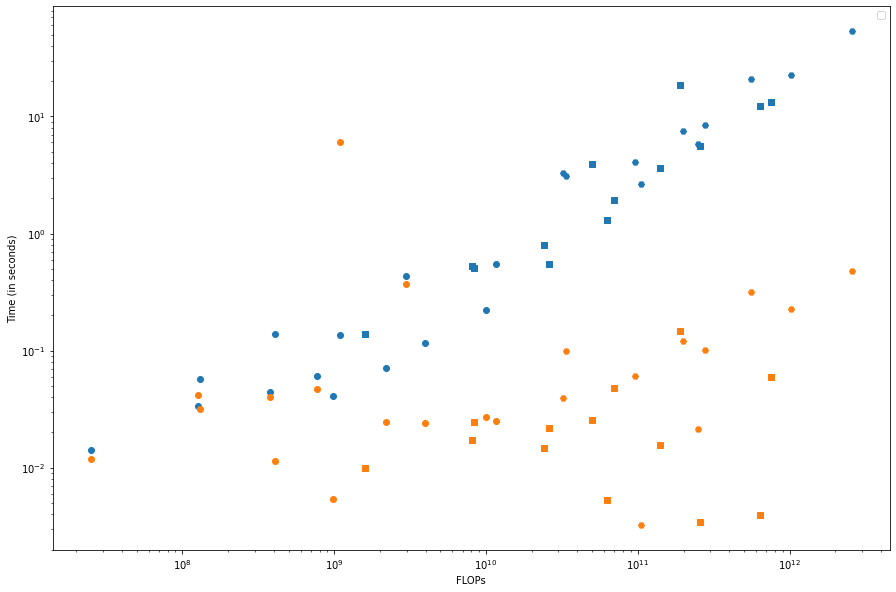

In [8]:
#Applies the latency to flops function to the model_dictionary 
flops_benchmark(batch_model)

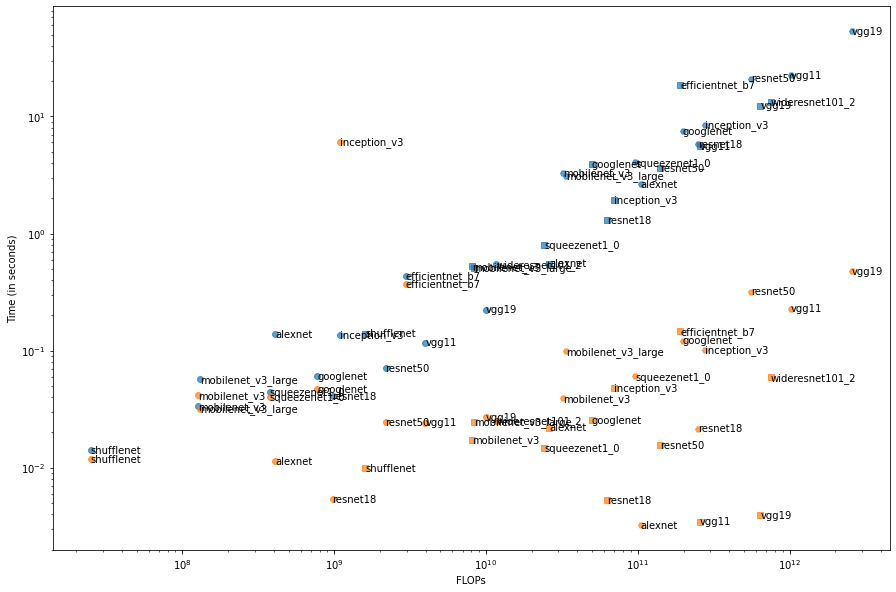

In [9]:
flops_benchmark_2(batch_model)

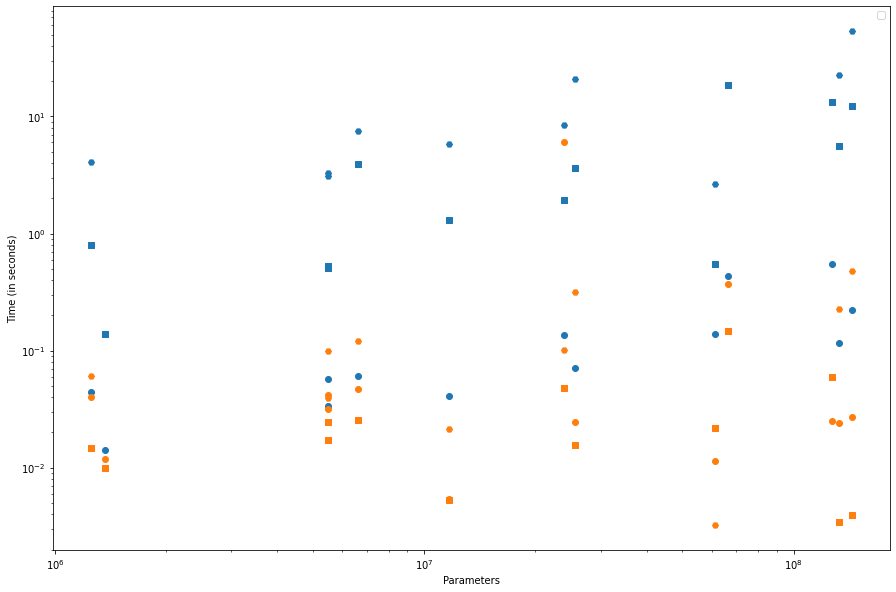

In [10]:
#Applies the latency to parameters function to the model_dictionary 
plot_param_benchmark(batch_model)

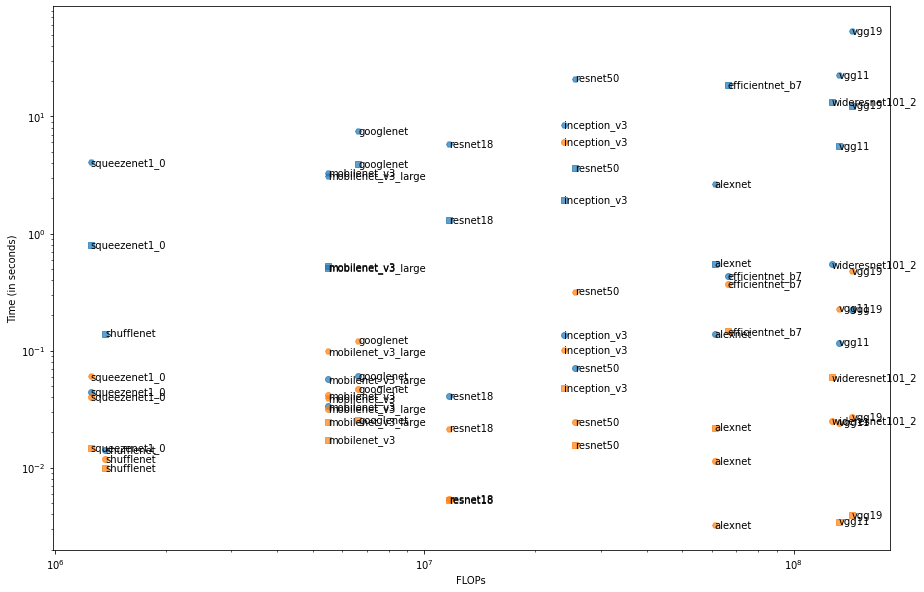

In [20]:
#Applies the latency to parameters function to the model_dictionary 
plot_param_benchmark_2(batch_model)

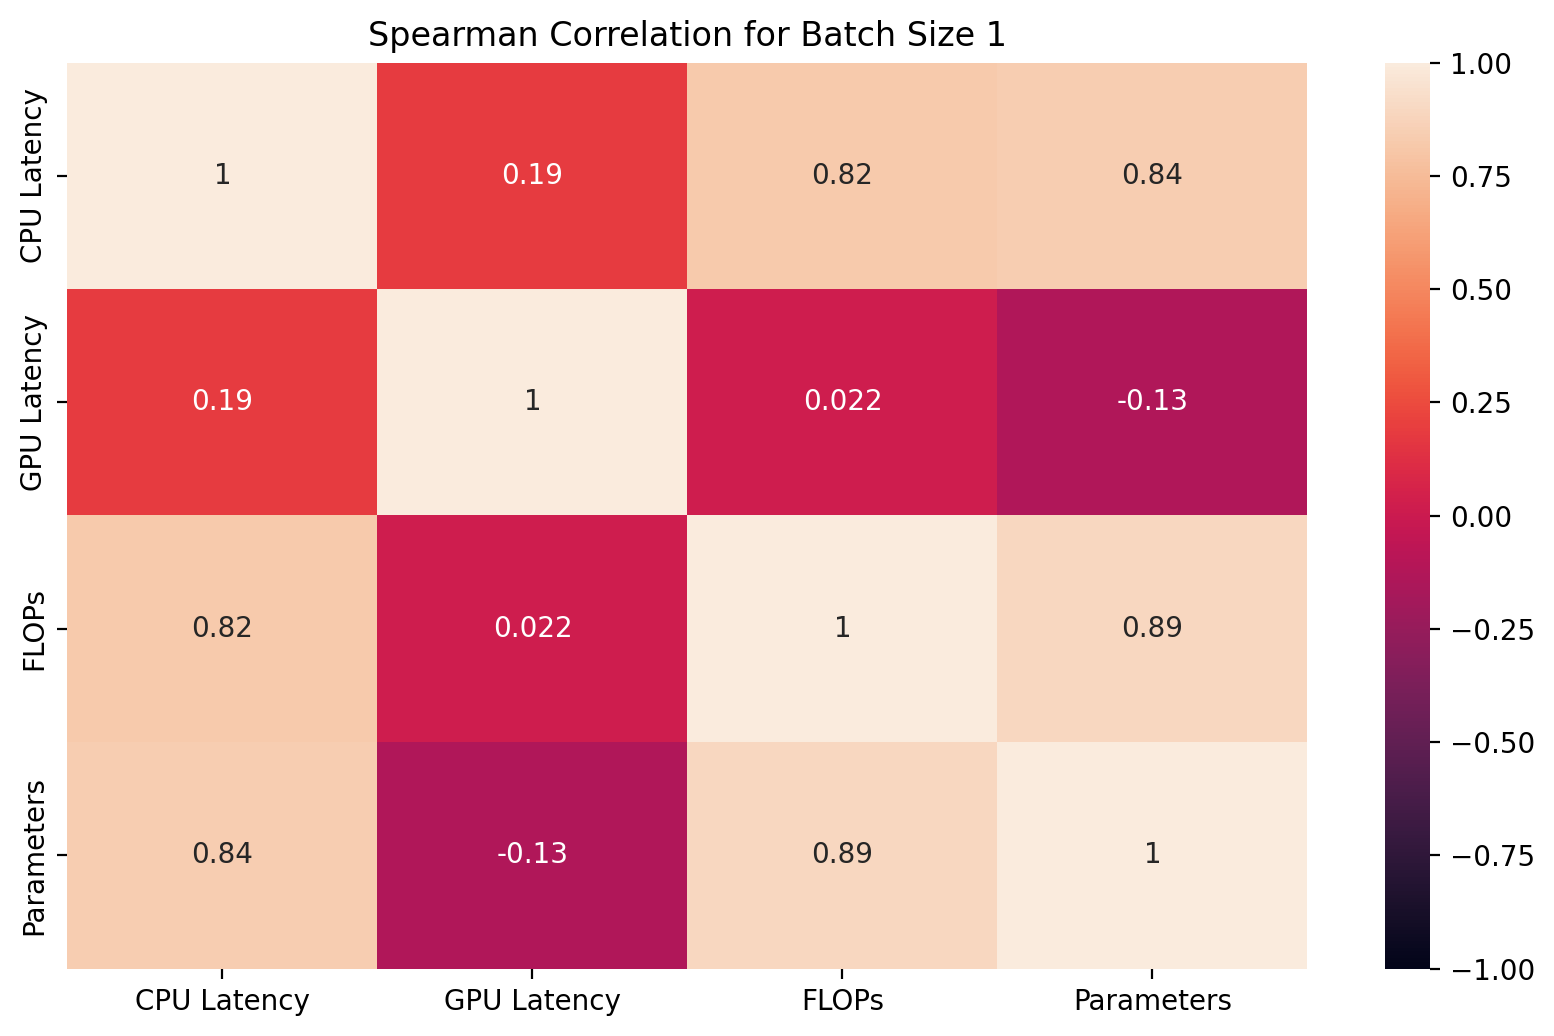

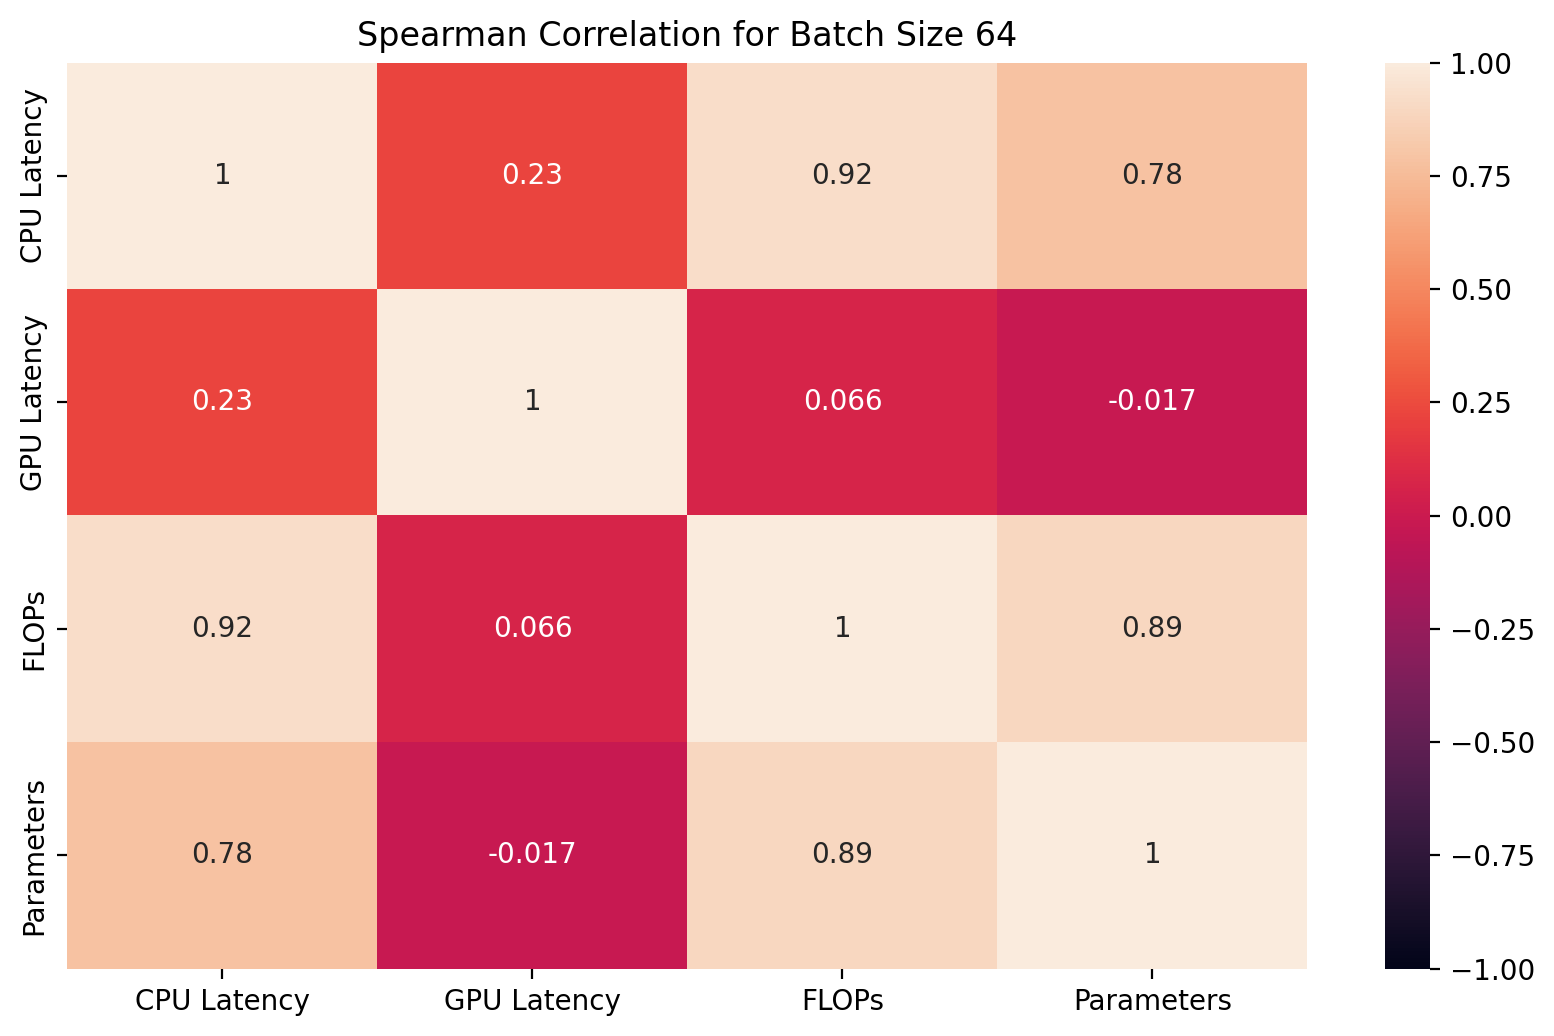

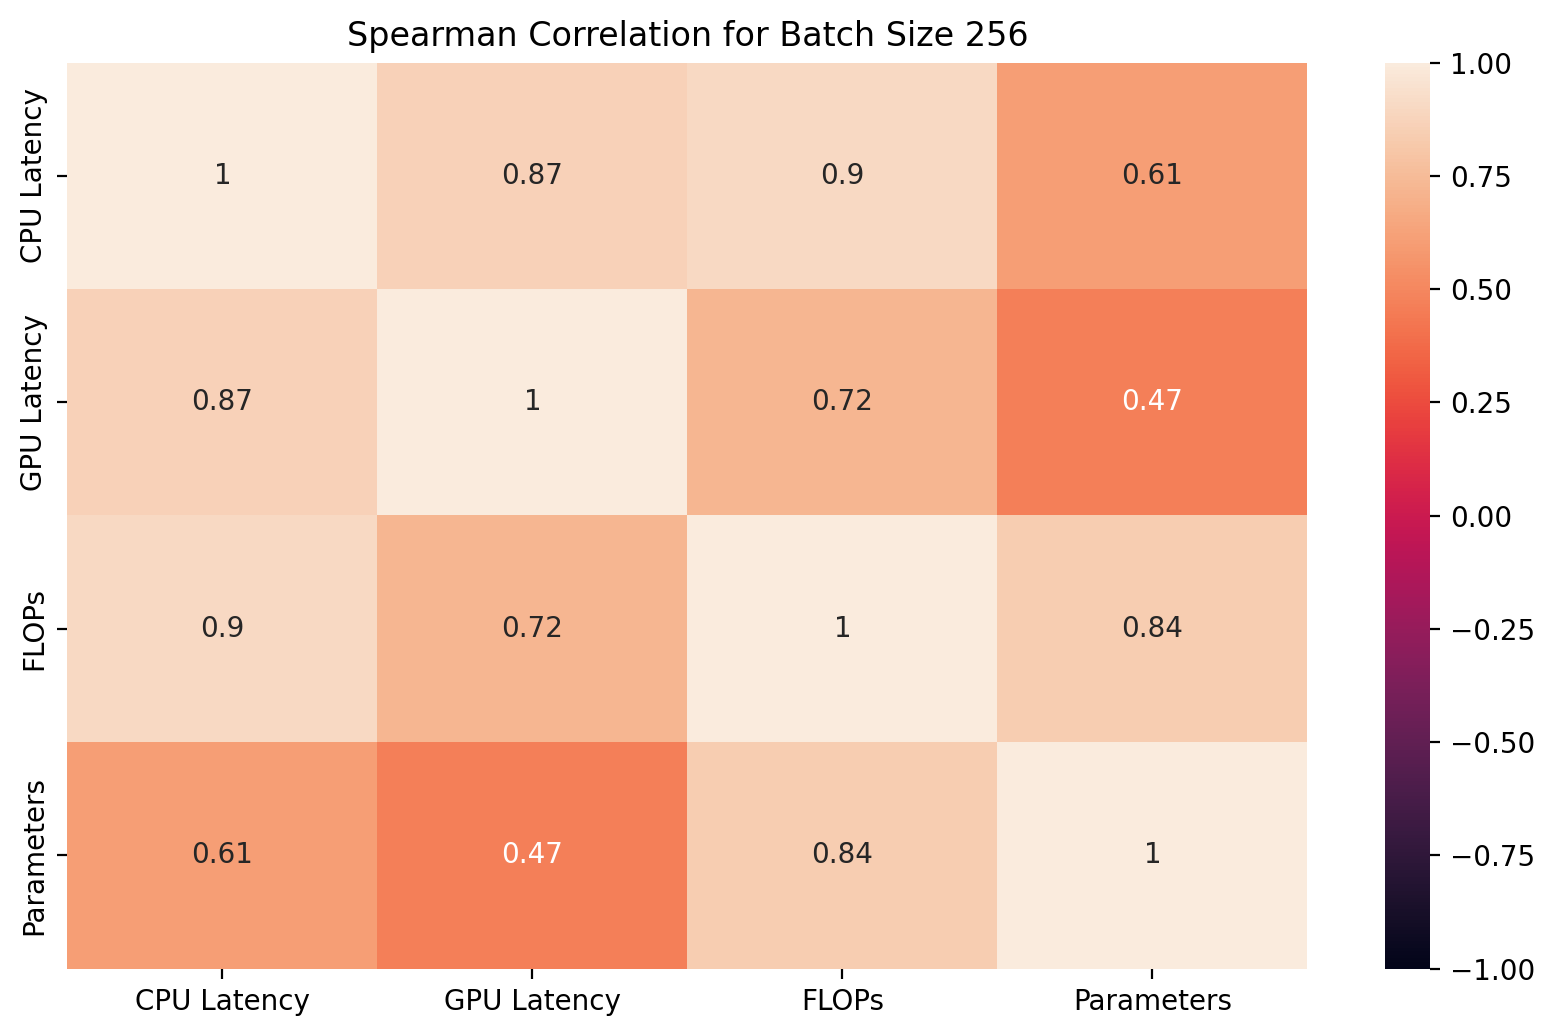

In [60]:
#Applies the spearman_correlation plotting function to the model_dictionary 
get_spearman(batch_model, 1)
get_spearman(batch_model, 64)
get_spearman(batch_model, 256)

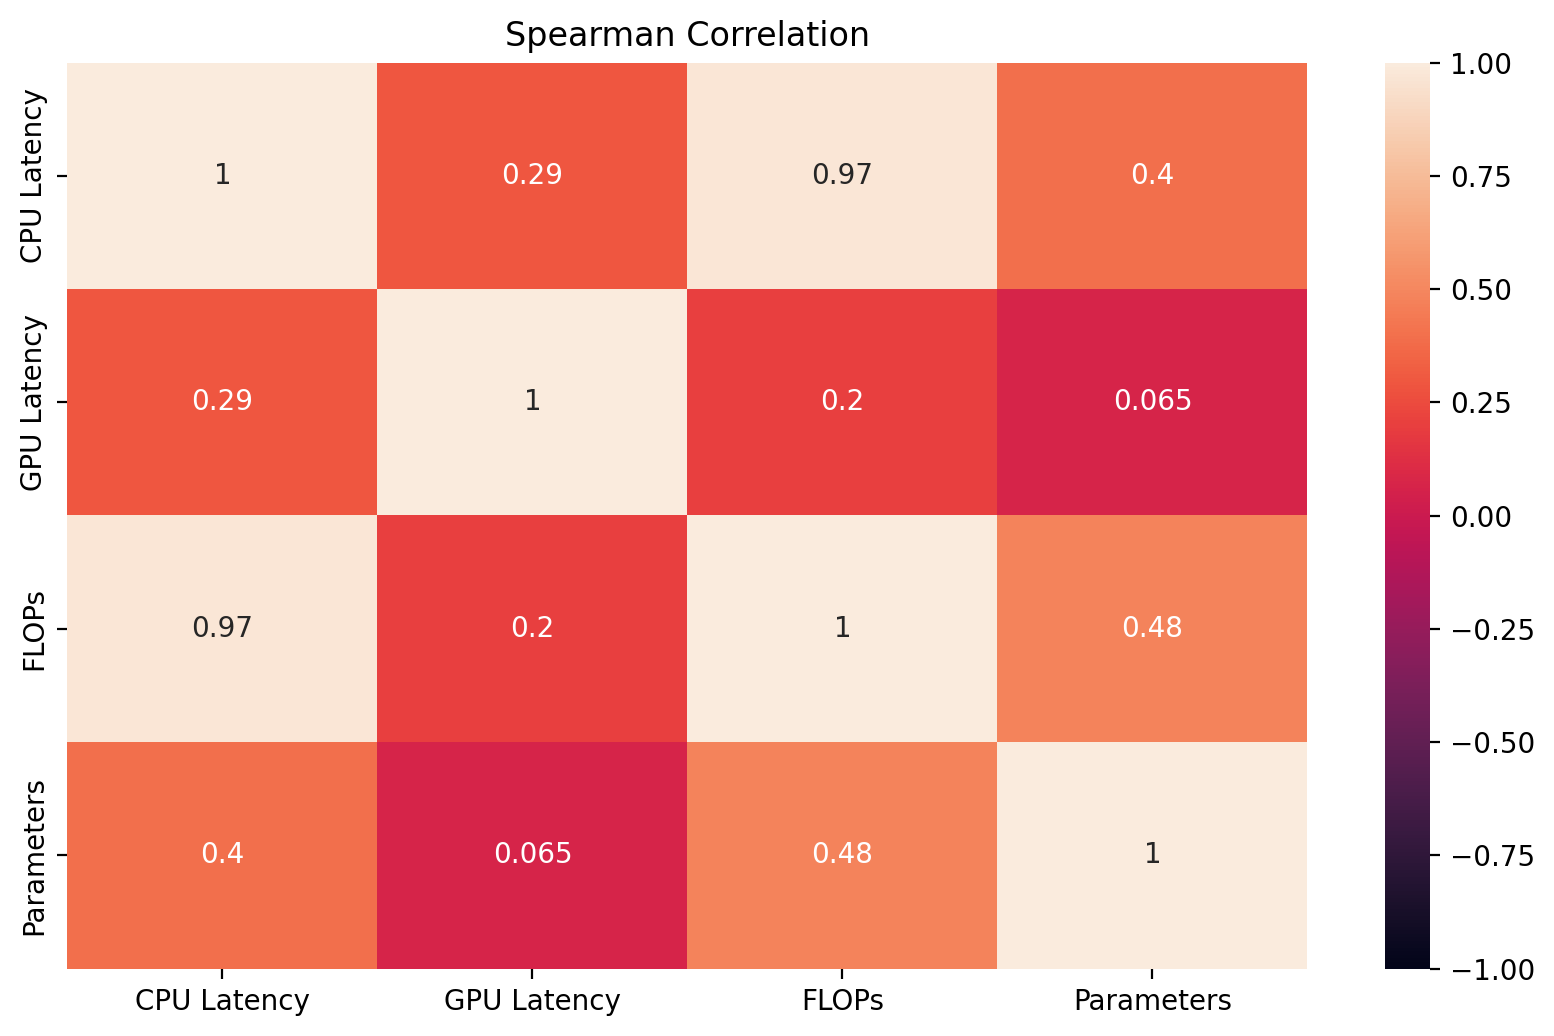

In [57]:
#Calls spearman correlation for one plot 
plot_spearman_correlation(batch_model)

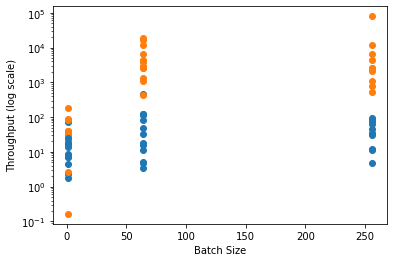

In [67]:
#Applies the throughput function to the model_dictionary 
plot_throughput(batch_model)

## Part Four: Hardware Utilization and Peak Performance
<ul type= "circle">
<li> Go back to the CPU/GPU rooflines from part 2 and plot the actual performance (at different batch sizes) of each model on the roofline.</li>
<li> Comment on any gaps between peak and achieved performance.</li>
</ul>

In [42]:
def roofline(cpu_gpu_dict, models={}, model_perf={}):
    """
    Plots the roofline graph for different devices and models.

    Args:
        cpu_gpu_dict (dict): A dictionary containing device names, GFlops, and memory bandwidth values.
        models (dict, optional): A dictionary containing model names and operational intensity values.
        model_perf (dict, optional): A dictionary containing performance information for different models and devices.
    """
    # Loop through each device in the input dictionary
    for device_name, device_data in cpu_gpu_dict.items():
        # Generate x-axis values
        x = np.linspace(1, 1000)

        # Extract GFlops and memory bandwidth values for the device
        gflops = device_data['GF']
        memory_bandwidth = device_data['MB']

        # Calculate meeting point
        meeting_point = gflops / memory_bandwidth

        # Generate y-axis values
        y = np.array([memory_bandwidth * current_x if current_x < meeting_point else gflops for current_x in x])

        # Plot the device line
        plt.plot([1, meeting_point, 1000], [memory_bandwidth, gflops, gflops], label=device_name)

        # Plot the model markers
        if models and device_name in ['GPU', 'CPU']:
            for model_name, model_data in models.items():
                oi = model_data['oi']

                # If model_perf is provided, get performance values for different batch sizes
                if model_perf:
                    y_vals = [memory_bandwidth * oi if oi < meeting_point else gflops]
                    for batch in [1, 64, 256]:
                        if f"batch_{batch}_time" in model_perf[model_name][device_name.lower()]:
                            y_vals.append(model_perf[model_name]['GF'] / model_perf[model_name][device_name.lower()][f"batch_{batch}_time"])
                    marker = "*" if device_name == 'GPU' else "P"
                    plt.scatter([oi] * len(y_vals), y_vals, marker=marker, label=model_name)
                else:
                    marker = "*" if device_name == 'GPU' else "P"
                    plt.scatter([oi], [memory_bandwidth * oi if oi < meeting_point else gflops], marker=marker, label=model_name)

    # Set x-axis and y-axis scales to logarithmic
    plt.xscale('log')
    plt.yscale('log')
    
    # Set x-axis and y-axis labels
    plt.xlabel('OPs/Bytes (log scale)')
    plt.ylabel('OPs/s (log scale)')
    
    # Display the legend and the plot
    plt.legend()
    plt.show()

In [38]:
#Creates dictionaries 
colab = {'GPU': {'GF': 8100, 'MB': 320},
        'CPU': {'GF': 662.4, 'MB':  68}}

batch_1 = {'alexnet': {'GF': 1.43, 'MB': 242.03, 
  'cpu': {'batch_1_flops': 408914304.0,
          'batch_1_params': 61100840.0,
          'batch_1_time': 0.13910126686096191,
          'batch_64_flops': 26170515456.0,
          'batch_64_params': 61100840.0,
          'batch_64_time': 0.5528178215026855,
          'batch_256_flops': 104682061824.0,
          'batch_256_params': 61100840.0,
          'batch_256_time': 2.6597251892089844},           
  'gpu': {'batch_1_flops': 408914304.0,
          'batch_1_params': 61100840.0,
          'batch_1_time': 0.011379480361938477,
          'batch_64_flops': 26170515456.0,
          'batch_64_params': 61100840.0,
          'batch_64_time': 0.022037744522094727,
          'batch_256_flops': 104682061824.0,
          'batch_256_params': 61100840.0,
          'batch_256_time': 0.0032219886779785156},
  'oi': 5.908358467958517},
  'shufflenet': {'GF': 0.09,'MB': 30.85,
  'cpu': {'batch_1_flops': 24892128.0,
          'batch_1_params': 1366792.0,
          'batch_1_time': 0.014089822769165039,
          'batch_64_flops': 1593096192.0,
          'batch_64_params': 1366792.0,
          'batch_64_time': 0.13978195190429688},
  'gpu': {'batch_1_flops': 24892128.0,
          'batch_1_params': 1366792.0,
          'batch_1_time': 0.011913299560546875,
          'batch_64_flops': 1593096192.0,
          'batch_64_params': 1366792.0,
          'batch_64_time': 0.009972810745239258},
  'oi': 2.917341977309562},
  'wideresnet101_2': {'GF': 1.65,'MB': 97.14,
  'cpu': {'batch_1_flops': 11707799552.0,
          'batch_1_params': 126886696.0,
          'batch_1_time': 0.5459306240081787,
          'batch_64_flops': 749299171328.0,
          'batch_64_params': 126886696.0,
          'batch_64_time': 13.23681378364563},
  'gpu': {'batch_1_flops': 11707799552.0,
          'batch_1_params': 126886696.0,
          'batch_1_time': 0.02516627311706543,
          'batch_64_flops': 749299171328.0,
          'batch_64_params': 126886696.0,
          'batch_64_time': 0.05903339385986328},
  'oi': 16.9857936998147},
  'inception_v3': {'GF': 5.69, 'MB': 209.48, 
  'cpu': {'batch_1_flops': 1084523072.0,
          'batch_1_params': 23834568.0,
          'batch_1_time': 0.13658428192138672,
          'batch_64_flops': 69409476608.0,
          'batch_64_params': 23834568.0,
          'batch_64_time': 1.9373373985290527,
          'batch_256_flops': 277637906432.0,
          'batch_256_params': 23834568.0,
          'batch_256_time': 8.43899416923523},
  'gpu': {'batch_1_flops': 1084523072.0,
          'batch_1_params': 23834568.0,
          'batch_1_time': 6.073119163513184,
          'batch_64_flops': 69409476608.0,
          'batch_64_params': 23834568.0,
          'batch_64_time': 0.047777652740478516,
          'batch_256_flops': 277637906432.0,
          'batch_256_params': 23834568.0,
          'batch_256_time': 0.10109710693359375},
  'oi': 27.162497613137294}}

batch_2 = {
    'mobilenet_v3': {'GF': 0.45,'MB': 126.9,
  'cpu': {'batch_1_flops': 126229424.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.033350467681884766,
          'batch_256_flops': 32314732544.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 3.3069205284118652,
          'batch_64_flops': 8078683136.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.5233912467956543},
  'gpu': {'batch_1_flops': 126229424.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.04151201248168945,
          'batch_256_flops': 32314732544.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 0.03913736343383789,
          'batch_64_flops': 8078683136.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.01717090606689453},
  'oi': 3.5460992907801416},
  'efficientnet_b7': {'GF': 10.53,'MB': 1330,
  'cpu': {'batch_1_flops': 2967297184.0,
          'batch_1_params': 66347960.0,
          'batch_1_time': 0.4362795352935791,
          'batch_64_flops': 189907019776.0,
          'batch_64_params': 66347960.0,
          'batch_64_time': 18.582102060317993},
  'gpu': {'batch_1_flops': 2967297184.0,
          'batch_1_params': 66347960.0,
          'batch_1_time': 0.3726234436035156,
          'batch_64_flops': 189907019776.0,
          'batch_64_params': 66347960.0,
          'batch_64_time': 0.1457521915435791},
  'oi': 7.917293233082707},
  'squeezenet1_0': {'GF': 1.65, 'MB': 97.14,
  'cpu': {'batch_1_flops': 376806736.0,
          'batch_1_params': 1248424.0,
          'batch_1_time': 0.04456162452697754,
          'batch_64_flops': 24115631104.0,
          'batch_64_params': 1248424.0,
          'batch_64_time': 0.7951359748840332,
          'batch_256_flops': 96462524416.0,
          'batch_256_params': 1248424.0,
          'batch_256_time': 4.062472581863403},
  'gpu': {'batch_1_flops': 376806736.0,
          'batch_1_params': 1248424.0,
          'batch_1_time': 0.0404362678527832,
          'batch_64_flops': 24115631104.0,
          'batch_64_params': 1248424.0,
          'batch_64_time': 0.014661550521850586,
          'batch_256_flops': 96462524416.0,
          'batch_256_params': 1248424.0,
          'batch_256_time': 0.06029772758483887},
  'oi': 16.9857936998147},
  'vgg19': {'GF': 39.29, 'MB': 787.31, 
  'cpu': {'batch_1_flops': 10001541120.0,
          'batch_1_params': 143667240.0,
          'batch_1_time': 0.22405195236206055,
          'batch_64_flops': 640098631680.0,
          'batch_64_params': 143667240.0,
          'batch_64_time': 12.35991382598877,
          'batch_256_flops': 2560394526720.0,
          'batch_256_params': 143667240.0,
          'batch_256_time': 53.55769371986389},
  'gpu': {'batch_1_flops': 10001541120.0,
          'batch_1_params': 143667240.0,
          'batch_1_time': 0.027074813842773438,
          'batch_64_flops': 640098631680.0,
          'batch_64_params': 143667240.0,
          'batch_64_time': 0.003940105438232422,
          'batch_256_flops': 2560394526720.0,
          'batch_256_params': 143667240.0,
          'batch_256_time': 0.48122596740722656},
  'oi': 49.90410384727744}
}

batch_3 = {'googlenet': {'GF': 3.01, 'MB': 119.95,
  'cpu': {'batch_1_flops': 774690432.0,
          'batch_1_params': 6624904.0,
          'batch_1_time': 0.061057090759277344,
          'batch_64_flops': 49580187648.0,
          'batch_64_params': 6624904.0,
          'batch_64_time': 3.9398393630981445,
          'batch_256_flops': 198320750592.0,
          'batch_256_params': 6624904.0,
          'batch_256_time': 7.438979387283325},
 'gpu': {'batch_1_flops': 774690432.0,
         'batch_1_params': 6624904.0,
         'batch_1_time': 0.04703545570373535,
         'batch_64_flops': 49580187648.0,
         'batch_64_params': 6624904.0,
         'batch_64_time': 0.025586605072021484,
         'batch_256_flops': 198320750592.0,
         'batch_256_params': 6624904.0,
         'batch_256_time': 0.1215727329254150},
  'oi': 25.093789078782823},
  'mobilenet_v3_large': {'GF': 0.47, 'MB': 126.9,
  'cpu': {'batch_1_flops': 130708352.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.05689859390258789,
          'batch_64_flops': 8365334528.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.5098750591278076,
          'batch_256_flops': 33461338112.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 3.123216390609741},
  'gpu': {'batch_1_flops': 130708352.0,
          'batch_1_params': 5483032.0,
          'batch_1_time': 0.03197765350341797,
          'batch_64_flops': 8365334528.0,
          'batch_64_params': 5483032.0,
          'batch_64_time': 0.0245530605316162,
          'batch_256_flops': 33461338112.0,
          'batch_256_params': 5483032.0,
          'batch_256_time': 0.09846353530883789},                                 
  'oi': 3.7037037037037033},
  'resnet18': {'GF': 3.65, 'MB': 107.96, 
  'cpu': {'batch_1_flops': 975780864.0,
          'batch_1_params': 11689512.0,
          'batch_1_time': 0.04091501235961914,
          'batch_64_flops': 62449975296.0,
          'batch_64_params': 11689512.0,
          'batch_64_time': 1.2949855327606201,
          'batch_256_flops': 249799901184.0,
          'batch_256_params': 11689512.0,
          'batch_256_time': 5.764563798904419},
  'gpu': {'batch_1_flops': 975780864.0,
          'batch_1_params': 11689512.0,
          'batch_1_time': 0.005395412445068359,
          'batch_64_flops': 62449975296.0,
          'batch_64_params': 11689512.0,
          'batch_64_time': 0.0053217411041259766,
          'batch_256_flops': 249799901184.0,
          'batch_256_params': 11689512.0,
          'batch_256_time': 0.02161431312561035},
  'oi': 33.808818080770656},
  'vgg11': {'GF': 15.2, 'MB': 632.78, 
  'cpu': {'batch_1_flops': 3990054912.0,
          'batch_1_params': 132863336.0,
          'batch_1_time': 0.11728382110595703,
          'batch_64_flops': 255363514368.0,
          'batch_64_params': 132863336.0,
          'batch_64_time': 5.5948710441589355,
          'batch_256_flops': 1021454057472.0,
          'batch_256_params': 132863336.0,
          'batch_256_time': 22.470963716506958},
  'gpu': {'batch_1_flops': 3990054912.0,
          'batch_1_params': 132863336.0,
          'batch_1_time': 0.024320363998413086,
          'batch_64_flops': 255363514368.0,
          'batch_64_params': 132863336.0,
          'batch_64_time': 0.0034601688385009766,
          'batch_256_flops': 1021454057472.0,
          'batch_256_params': 132863336.0,
          'batch_256_time': 0.22866177558898926},
  'oi': 24.02098675685072},
  'resnet50': {'GF': 8.22, 'MB': 384.62, 
  'cpu': {'batch_1_flops': 2178418688.0,
          'batch_1_params': 25557032.0,
          'batch_1_time': 0.0712122917175293,
          'batch_64_flops': 139418796032.0,
          'batch_64_params': 25557032.0,
          'batch_64_time': 3.6122326850891113,
          'batch_256_flops': 557675184128.0,
          'batch_256_params': 25557032.0,
          'batch_256_time': 21.036190509796143},
  'gpu': {'batch_1_flops': 2178418688.0,
          'batch_1_params': 25557032.0,
          'batch_1_time': 0.0246732234954834,
          'batch_64_flops': 139418796032.0,
          'batch_64_params': 25557032.0,
          'batch_64_time': 0.01570725440979004,
          'batch_256_flops': 557675184128.0,
          'batch_256_params': 25557032.0,
          'batch_256_time': 0.31880640983581543},
  'oi': 21.37174353907753}}

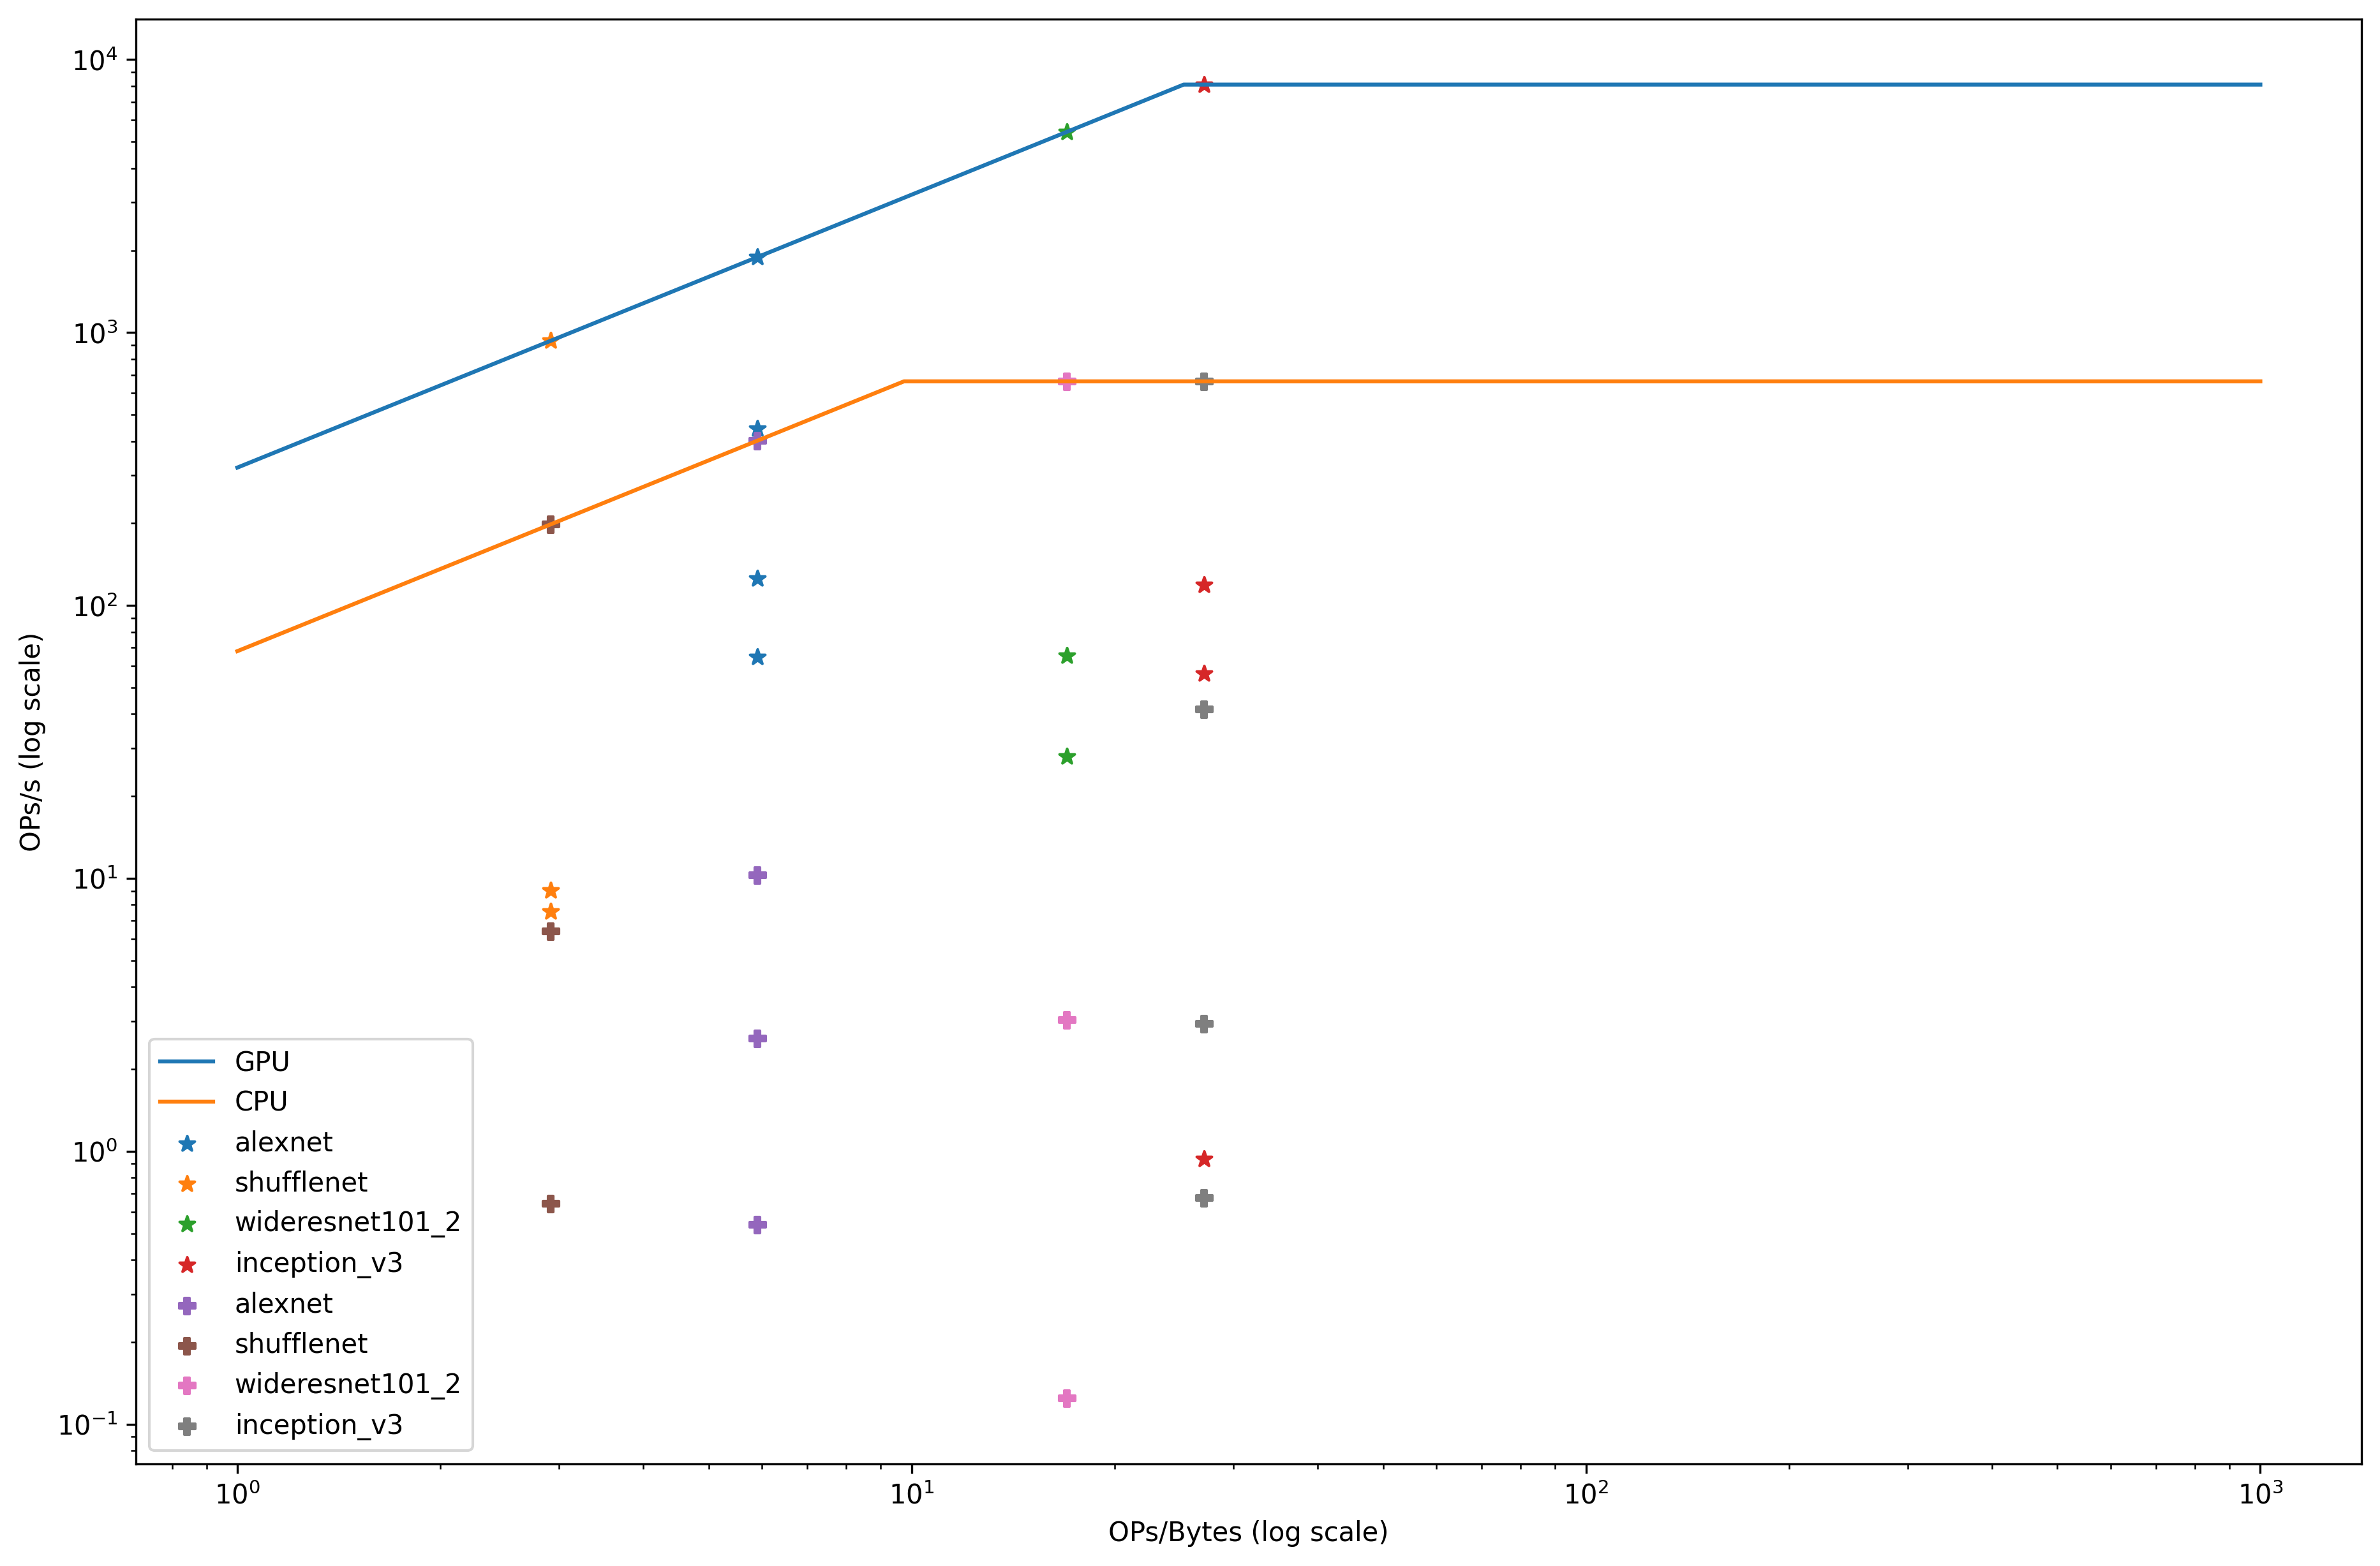

In [39]:
#Calls the roofline plot with actual performance
roofline(colab, batch_1, batch_1)

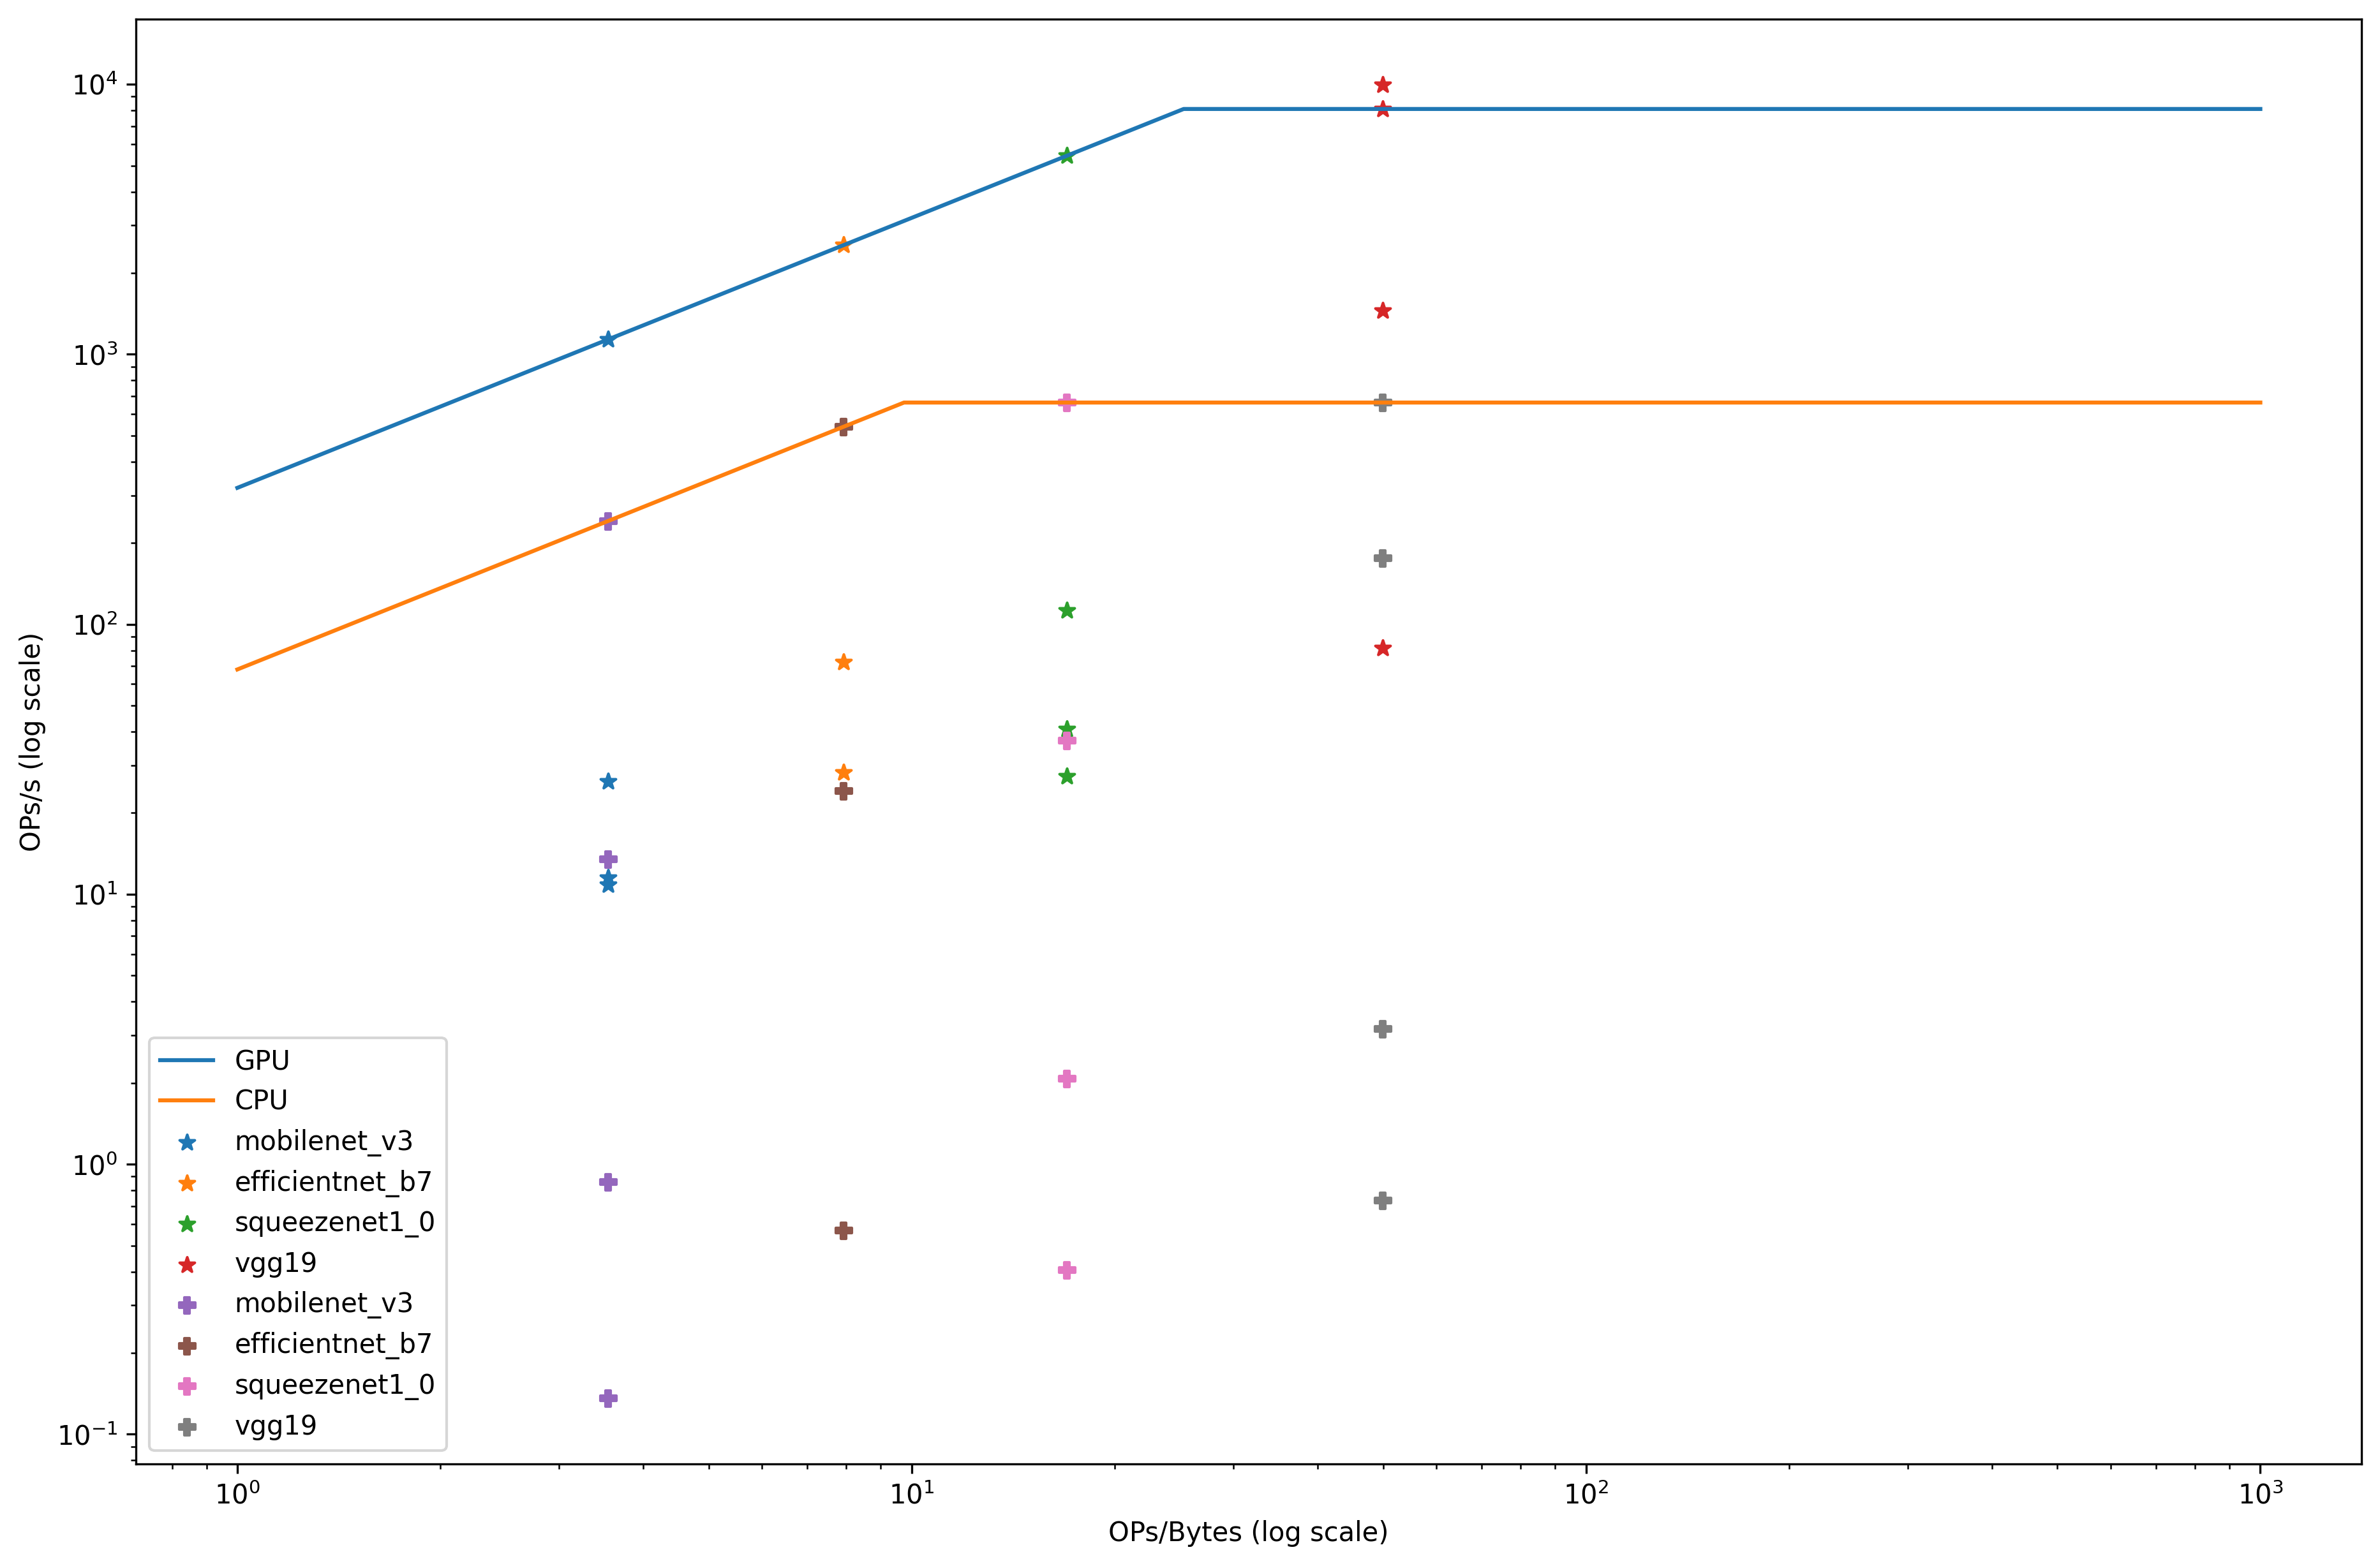

In [40]:
#Calls the roofline plot with actual performance
roofline(colab,batch_2, batch_2)

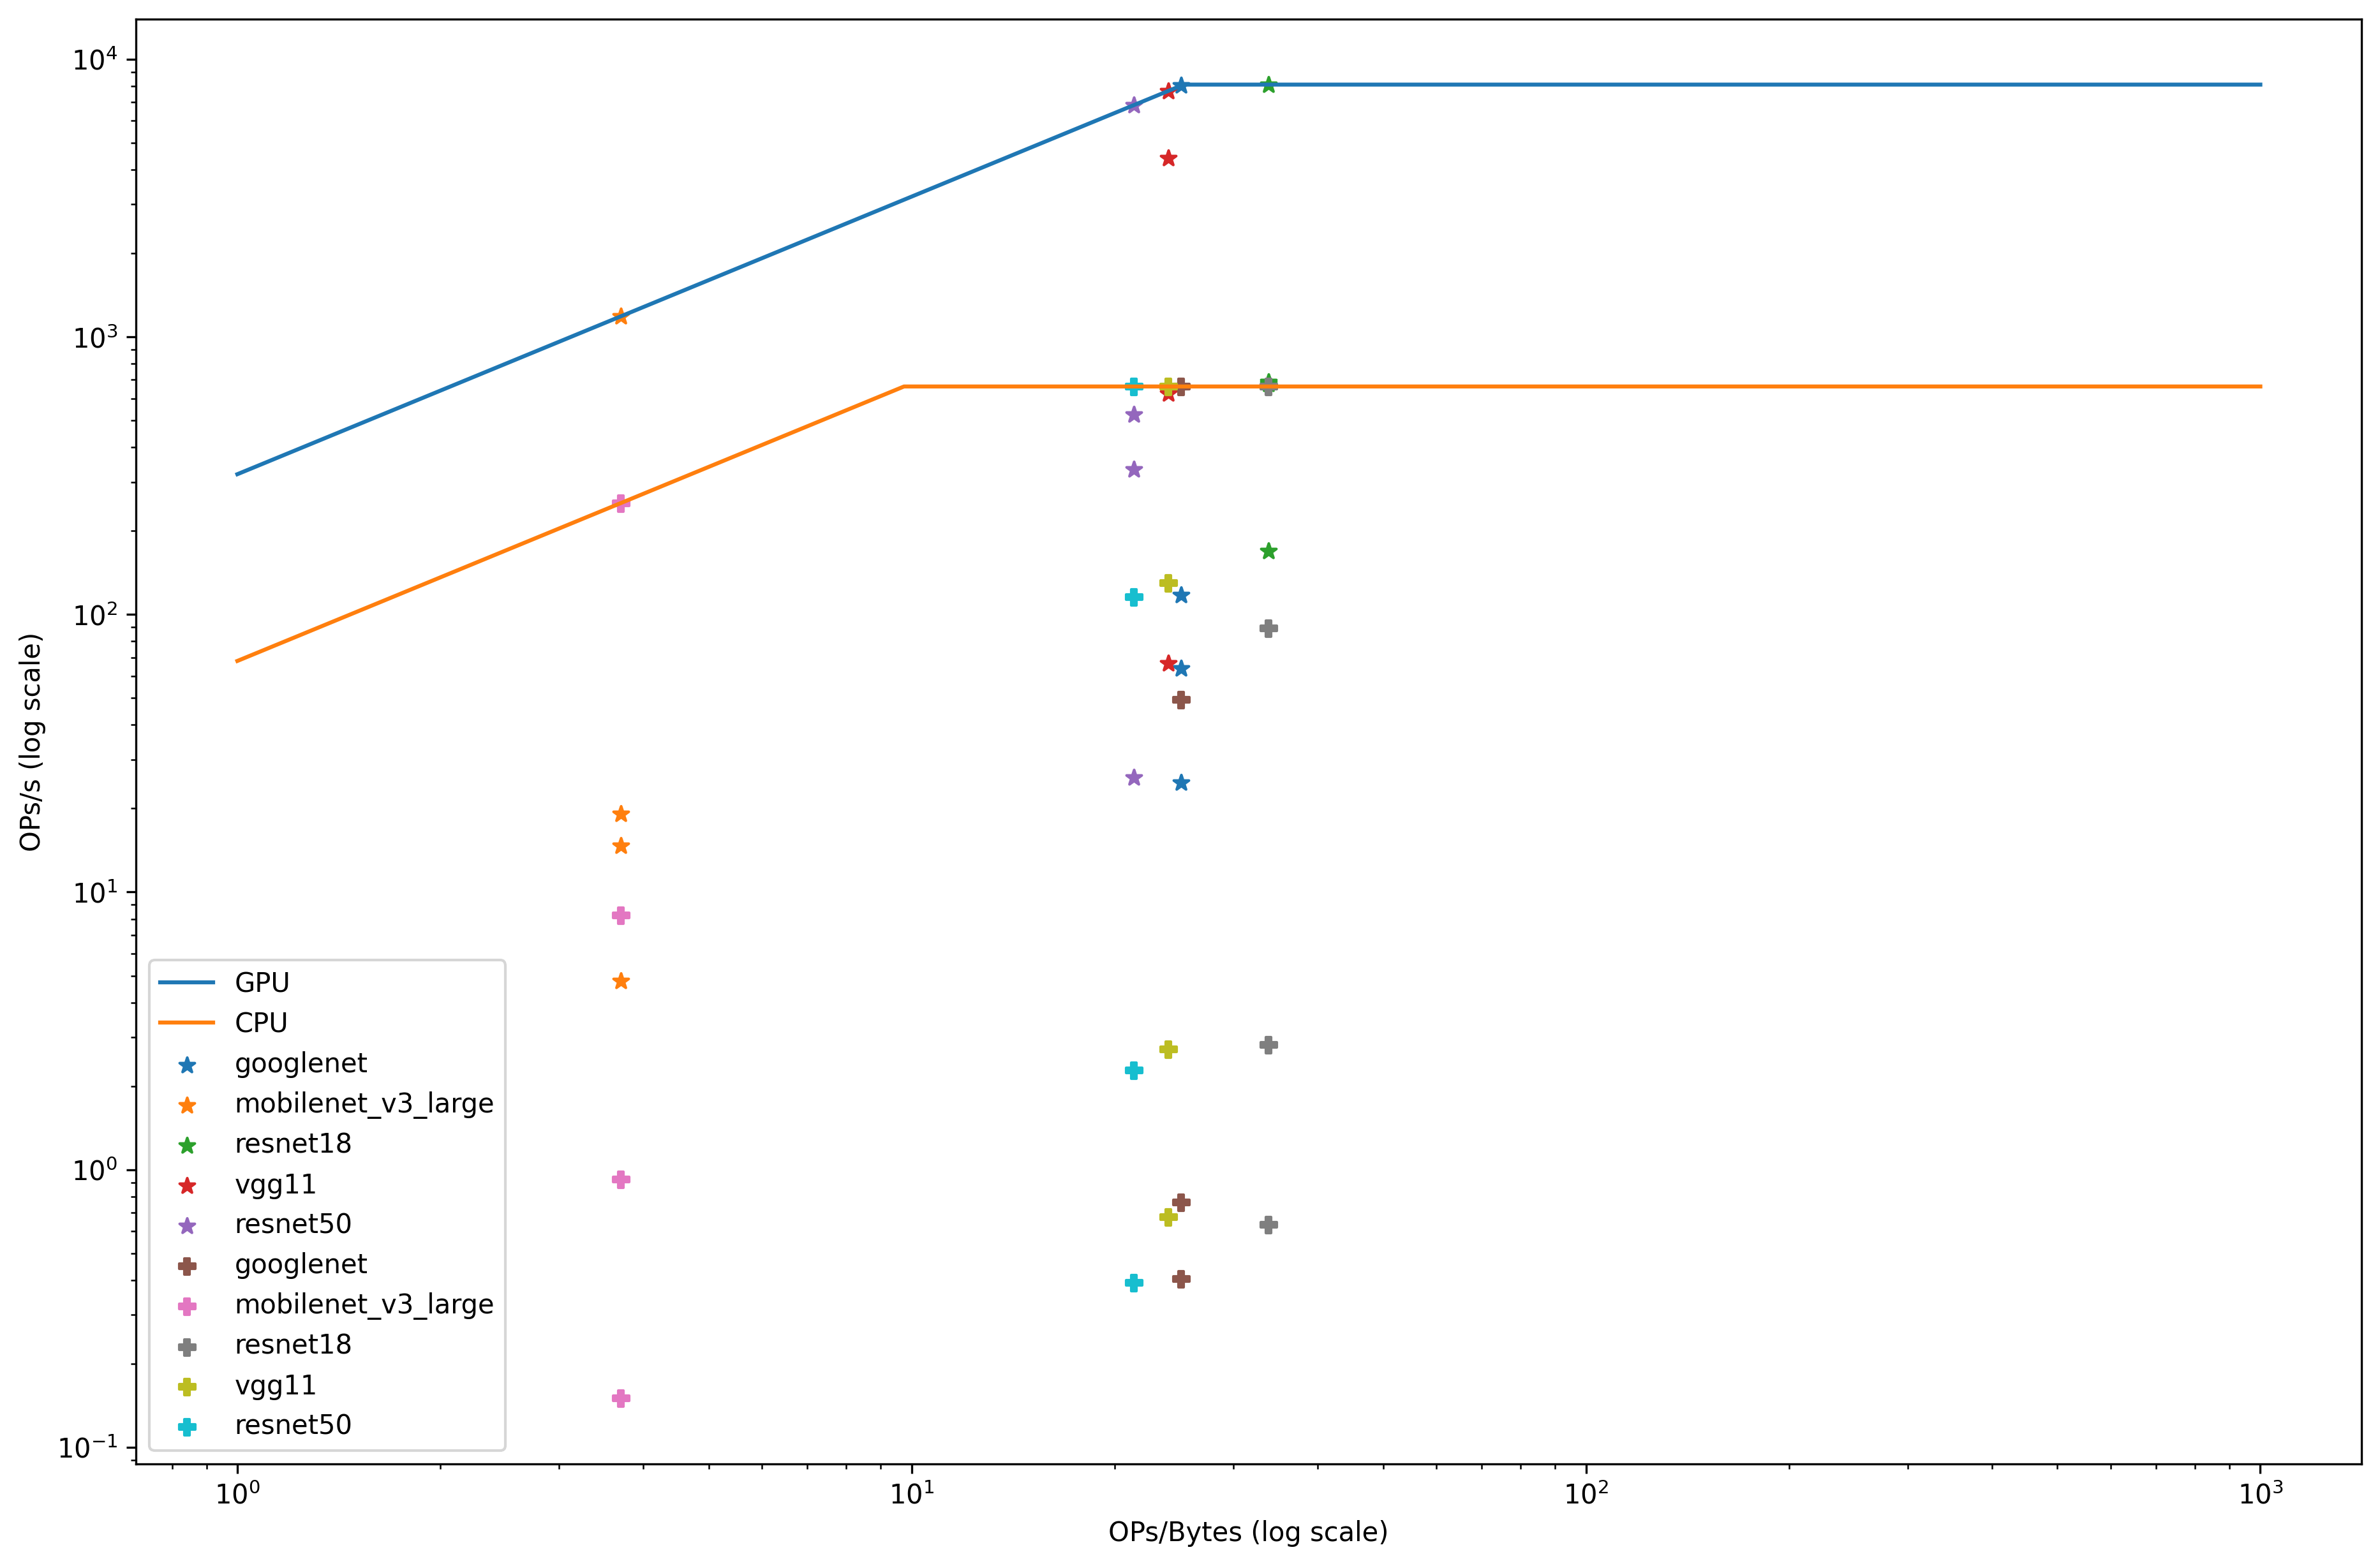

In [41]:
#Calls the roofline plot with actual performance
roofline(colab, batch_3, batch_3)

## Part Five: Inference vs training
<ul type= "circle">
<li>We would like to experimentally determine the ratio of computation that goes to the forward pass vs. the backward pass of a DNN. Compute the FLOPs and measure the runtime so some of your selected DNNs from part 2 when performing a backward pass. Compute the ratio of forward:backward pass, both in terms of FLOPs and latency. Choose a reasonable training batch size to complete this part. Comment on this ratio for different models. </li>
<li>For both the forward and backward passes, plot pie charts depicting the breakdown of latency, flops and memory footprint for each layer type in your chosen DNNs. </li>
</ul>

In [4]:
def profile_model_inference(model, inputs, profile_settings=None):
    """
    Profile the inference performance of a PyTorch model with the specified inputs and profiler settings.

    Args:
        model (torch.nn.Module): The PyTorch model to profile.
        inputs (torch.Tensor): The inputs to the model to use for profiling.
        profile_settings (dict): Optional dictionary of profiler settings. See the PyTorch documentation for
            `torch.profiler.profile` for more information.

    Returns:
        The PyTorch profiler object.
    """
    # Define default profiler settings
    if profile_settings is None:
        profile_settings = {
            'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],  # Record CPU and GPU usage
            'profile_memory': True,  # Record memory usage
            'record_shapes': True,  # Record shapes of input/output tensors
            'with_flops': True,  # Record FLOPs (floating-point operations) of each operation
        }

    # Create the profiler with the specified settings
    profiler = profile(**profile_settings)

    # Profile the model's inference performance
    with profiler:
        with record_function("model_inference"):
            model(inputs)

    return profiler


# Example usage:
model_name = 'vgg11'
model = models.__dict__[model_name]().to(torch.device('cuda'))
inputs = torch.randn(32, 3, 224, 224).to(torch.device('cuda'))
profiler = profile_model_inference(model, inputs)
print(profiler.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total GFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.14%       8.394ms        99.24%        5.798s        5.798s       0.000us         0.00%      93.176ms      93.176ms          -4 

In [5]:
def summarize_profiling_results(profiler):
    """
    Given a profiler object, extracts relevant information and stores it in a dictionary.
    """
    
    # Extract total forward flops
    events = profiler.events()
    forward_flops = sum([int(evt.flops) for evt in events])
    
    # Initialize dictionary to store summary information
    summary_dict = {}
    
    # Initialize counters for each layer type and total time/memory usage
    conv_time, conv_mem = 0, 0
    linear_time, linear_mem = 0, 0
    pool_time, pool_mem = 0, 0
    dropout_time, dropout_mem = 0, 0
    other_time, other_mem = 0, 0
    total_time, total_mem = 0, 0
    
    # Loop through profiler data and extract relevant information
    for data in profiler.key_averages():
        
        # Extract layer name
        data_str = str(data)
        layer_name = re.search(r'(?<=key=)[^\s]*', data_str)
        if layer_name:
            layer_name = layer_name.group(0)
        
        # Extract CUDA time (in seconds)
        cuda_time_str = re.search(r'(?<=cuda_time=)[^\s]*', data_str)
        if cuda_time_str:
            cuda_time = float(cuda_time_str.group(0)[:-2])
            if cuda_time_str.group(0)[-2:] == 'us':
                cuda_time /= 1000
        
        # Extract CUDA memory usage (in bytes)
        cuda_mem_str = re.search(r'(?<=cuda_memory_usage=)[^\>]*', data_str)
        if cuda_mem_str:
            cuda_mem = float(cuda_mem_str.group(0))
        
        # Update counters for relevant layer type
        total_time += cuda_time
        total_mem += cuda_mem
        if 'conv' in layer_name:
            conv_time += cuda_time
            conv_mem += cuda_mem
        elif 'linear' in layer_name:
            linear_time += cuda_time
            linear_mem += cuda_mem
        elif 'pool' in layer_name:
            pool_time += cuda_time
            pool_mem += cuda_mem
        elif 'dropout' in layer_name:
            dropout_time += cuda_time
            dropout_mem += cuda_mem
        else:
            other_time += cuda_time
            other_mem += cuda_mem
    
    # Store summary information in dictionary
    summary_dict["forward_conv_time"] = conv_time
    summary_dict["forward_linear_time"] = linear_time
    summary_dict["forward_pool_time"] = pool_time
    summary_dict["forward_dropout_time"] = dropout_time
    summary_dict["forward_other_time"] = other_time
    summary_dict["forward_total_time"] = total_time
    summary_dict["forward_conv_mem"] = conv_mem
    summary_dict["forward_linear_mem"] = linear_mem
    summary_dict["forward_pool_mem"] = pool_mem
    summary_dict["forward_dropout_mem"] = dropout_mem
    summary_dict["forward_other_mem"] = other_mem
    summary_dict["forward_total_mem"] = total_mem
    summary_dict["forward_flops"] = forward_flops
    
    return summary_dict

In [21]:
#Applies the torch profiler to the data
results = summarize_profiling_results(profiler)
results

{'forward_conv_time': 64.434,
 'forward_linear_time': 0.0,
 'forward_pool_time': 8.172,
 'forward_dropout_time': 0.019,
 'forward_other_time': 113.72699999999999,
 'forward_total_time': 186.35200000000006,
 'forward_conv_mem': 3802136576.0,
 'forward_linear_mem': 1176576.0,
 'forward_pool_mem': 1181876224.0,
 'forward_dropout_mem': 2621440.0,
 'forward_other_mem': 2216406016.0,
 'forward_total_mem': 7204216832.0,
 'forward_flops': 486981763072}

In [38]:

with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True, with_flops=True) as prof:
    output = model(inputs).sum()
    output.backward()

print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total GFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  cudaDeviceSynchronize        94.48%     245.876ms        94.48%     245.876ms     245.876ms       0.000us         0.00%       0.000us       0.000us           0 

In [32]:

def update_dict_ratios(prof, in_dict):
    """
    Extracts performance metrics from a PyTorch profiler object and updates a dictionary with the results.
    
    Args:
    - prof: PyTorch profiler object
    - in_dict: dictionary to be updated with the profiling results
    
    Returns:
    - None
    """

    # Initialize variables to store profiling results
    conv_time, conv_mem = 0, 0
    linear_time, linear_mem = 0, 0
    pool_time, pool_mem = 0, 0
    dropout_time, dropout_mem = 0, 0
    other_time, other_mem = 0, 0
    total_time, total_mem = 0, 0

    # Extract performance metrics from profiler object
    for i in prof.key_averages():
        s = str(i)
        key = re.search(r'(?<=key=)[^\s]*',s)
        if key:               
            name = key.group(0)
        cuda_time = re.search(r'(?<=cuda_time=)[^\s]*',s)
        if cuda_time:               
            ltime = cuda_time.group(0)
            dig = float(ltime[:-2])
            meas = ltime[-2:]
            if meas == 'us':
                dig /= 1000
        cuda_mem = re.search(r'(?<=cuda_memory_usage=)[^\>]*',s)
        if cuda_mem:               
            lmem = cuda_mem.group(0)
            dig_mem = float(lmem)
        total_time += dig
        total_mem += dig_mem
        if 'conv' in name:
            conv_time += dig
            conv_mem += dig_mem
        elif 'linear' in name:
            linear_time += dig
            linear_mem += dig_mem
        elif 'pool' in name:
            pool_time += dig
            pool_mem += dig_mem
        elif 'dropout' in name:
            dropout_time += dig
            dropout_mem += dig_mem
        else:
            other_time += dig
            other_mem += dig_mem

    # Update dictionary with profiling results
    in_dict["backward_conv_time"] = conv_time
    in_dict["backward_linear_time"] = linear_time
    in_dict["backward_pool_time"] = pool_time
    in_dict["backward_dropout_time"] = dropout_time
    in_dict["backward_total_time"] = total_time
    in_dict["backward_conv_mem"] = conv_mem
    in_dict["backward_linear_mem"] = linear_mem
    in_dict["backward_pool_mem"] = pool_mem
    in_dict["backward_dropout_mem"] = dropout_mem
    in_dict["backward_total_mem"] = total_mem
    
    return in_dict

In [33]:
#Applies the update dictionary function to the results dictionary 
results = update_dict_ratios(prof, results)


{'forward_conv_time': 173.171,
 'forward_linear_time': 0.023,
 'forward_pool_time': 25.43,
 'forward_dropout_time': 0.07,
 'forward_other_time': 113.72699999999999,
 'forward_total_time': 252.27399999999994,
 'forward_conv_mem': 4200515584.0,
 'forward_linear_mem': 1176576.0,
 'forward_pool_mem': 1970274304.0,
 'forward_dropout_mem': 3670016.0,
 'forward_other_mem': 2216406016.0,
 'forward_total_mem': 14888037888.0,
 'forward_flops': 486981763072,
 'backward_conv_time': 173.171,
 'backward_linear_time': 0.023,
 'backward_pool_time': 25.43,
 'backward_dropout_time': 0.07,
 'backward_total_time': 252.27399999999994,
 'backward_conv_mem': 4200515584.0,
 'backward_linear_mem': 1176576.0,
 'backward_pool_mem': 1970274304.0,
 'backward_dropout_mem': 3670016.0,
 'backward_total_mem': 14888037888.0}

In [11]:
results_vgg19 = {'forward_conv_time': 151.847,
'forward_linear_time': 0.0,
'forward_pool_time': 7.737,
'forward_dropout_time': 0.016,
'forward_total_time': 390.608,
'forward_conv_mem': 7604273152.0,
'forward_linear_mem': 1176576.0,
'forward_pool_mem': 1181745152.0,
'forward_dropout_mem': 2621440.0,
'forward_total_mem': 15491833856.0,
'backward_conv_time': 891.193,
'backward_linear_time': 0.023,
'backward_pool_time': 22.757,
'backward_dropout_time': 0.068,
'backward_total_time': 989.241,
'backward_conv_mem': 8997712896.0,
'backward_linear_mem': 1176576.0,
'backward_pool_mem': 1968504832.0,
'backward_dropout_mem': 3670016.0,
'backward_total_mem': 36218427904.0}

results_Googlenet = {'forward_conv_time': 28.373,
'forward_linear_time': 0.0,
'forward_pool_time': 9.864,
'forward_dropout_time': 0.024,
'forward_total_time': 100.12200000000003,
'forward_conv_mem': 1655660544.0,
'forward_linear_mem': 646144.0,
'forward_pool_mem': 1093009408.0,
'forward_dropout_mem': 983040.0,
'forward_total_mem': 5621356032.0,
'backward_conv_time': 29.932000000000002,
'backward_linear_time': 0.038,
'backward_pool_time': 9.682000000000002,
'backward_dropout_time': 0.06,
'backward_total_time': 54.96499999999999,
'backward_conv_mem': 1655660544.0,
'backward_linear_mem': 646144.0,
'backward_pool_mem': 1093009408.0,
'backward_dropout_mem': 983040.0,
'backward_total_mem': 4086383104.0}


results_mobilenet_v3_large= {'forward_conv_time': 17.08,
'forward_linear_time': 0.0,
'forward_pool_time': 0.0,
'forward_dropout_time': 0.0,
'forward_total_time': 68.57999999999996,
'forward_conv_mem': 2261856256.0,
'forward_linear_mem': 291840.0,
'forward_pool_mem': 642048.0,
'forward_dropout_mem': 163840.0,
'forward_total_mem': 5928791552.0,
'backward_conv_time': 85.867,
'backward_linear_time': 0.016,
'backward_pool_time': 0.044,
'backward_dropout_time': 0.019,
'backward_total_time': 138.72000000000003,
'backward_conv_mem': 2836221440.0,
'backward_linear_mem': 291840.0,
'backward_pool_mem': 642048.0,
'backward_dropout_mem': 163840.0,
'backward_total_mem': 9737034240.0}


results_Resnet50= {'forward_conv_time': 81.983,
'forward_linear_time': 0.0,
'forward_pool_time': 1.253,
'forward_dropout_time': 0,
'forward_total_time': 246.274,
'forward_conv_mem': 5698322432.0,
'forward_linear_mem': 128000.0,
'forward_pool_mem': 154402816.0,
'forward_dropout_mem': 0,
'forward_total_mem': 13920136704.0,
'backward_conv_time': 268.139,
'backward_linear_time': 0.008,
'backward_pool_time': 3.4929999999999994,
'backward_dropout_time': 0,
'backward_total_time': 377.04300000000006,
'backward_conv_mem': 7141749760.0,
'backward_linear_mem': 128000.0,
'backward_pool_mem': 257163264.0,
'backward_dropout_mem': 0,
'backward_total_mem': 24491118080.0}


results_AlexNet = {'forward_conv_time': 7.43,
'forward_linear_time': 0.0,
'forward_pool_time': 0.854,
'forward_dropout_time': 0.021,
'forward_total_time': 23.302000000000003,
'forward_conv_mem': 248315904.0,
'forward_linear_mem': 1176576.0,
'forward_pool_mem': 74694656.0,
'forward_dropout_mem': 5423104.0,
'forward_total_mem': 560930304.0,
'backward_conv_time': 21.703,
'backward_linear_time': 0.022,
'backward_pool_time': 3.1550000000000002,
'backward_dropout_time': 0.074,
'backward_total_time': 34.53099999999999,
'backward_conv_mem': 283959296.0,
'backward_linear_mem': 1176576.0,
'backward_pool_mem': 125714432.0,
'backward_dropout_mem': 8323072.0,
'backward_total_mem': 1944825856.0}

In [16]:
import matplotlib.pyplot as plt

def plot_results_time(results):
    """
    This function generates two sets of pie charts, one showing the breakdown of forward and backward time for 
    each layer type, and another showing the breakdown of total time for forward and backward passes. 
    
    Args:
    results (dict): Dictionary containing the results of a machine learning model's forward and backward passes.
    
    Returns:
    None
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot pie chart for time breakdown of each layer type in forward pass
    ax1.pie([1000*results['forward_conv_time'], 
             1000*results['forward_linear_time'], 
             1000*results['forward_pool_time'], 
             1000*results['forward_dropout_time']], 
            labels=['Conv', 'Linear', 'Pool', 'Dropout'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE', '#87CEFA', '#FFC0CB']) # use colorblind friendly colors
    ax1.set_title('Forward')

    # Plot pie chart for time breakdown of each layer type in backward pass
    ax2.pie([1000*results['backward_conv_time'], 
             1000*results['backward_linear_time'], 
             1000*results['backward_pool_time'], 
             1000*results['backward_dropout_time']], 
            labels=['Conv', 'Linear', 'Pool', 'Dropout'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE', '#87CEFA', '#FFC0CB']) # use colorblind friendly colors
    ax2.set_title('Backward')

    plt.show()



In [31]:
def plot_layers_forward(results):
  # Create figure with five subplots
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

    # Plot pie chart for time breakdown of conv layers in forward and backward passes
    ax1.pie([1000*results['forward_conv_time'], 
             1000*results['backward_conv_time']], 
            #labels=['Forward time', 'Backward time'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax1.set_title('Conv ')

    # Plot pie chart for time breakdown of linear layers in forward and backward passes
    ax2.pie([1000*results['forward_linear_time'], 
             1000*results['backward_linear_time']], 
            #labels=['Forward time', 'Backward time'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax2.set_title('Linear ')

    # Plot pie chart for time breakdown of pooling layers in forward and backward passes
    ax3.pie([1000*results['forward_pool_time'], 
             1000*results['backward_pool_time']], 
            #labels=['Forward time', 'Backward time'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax3.set_title('Pooling ')

    # Plot pie chart for time breakdown of dropout layers in forward and backward passes
    ax4.pie([1000*results['forward_dropout_time'], 
             1000*results['backward_dropout_time']], 
            #labels=['Forward Dropout', 'Backward Dropout'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax4.set_title('Dropout ')


    # Plot pie chart for time breakdown of total time in layers in forward and backward passes
    ax5.pie([1000*results['forward_total_time'], 
             1000*results['backward_total_time']], 
            #labels=['Forward Total Time', 'Backward Total Time'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax5.set_title('Total Time')

    plt.show()

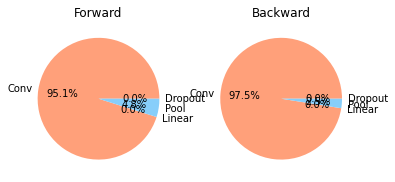

In [23]:
plot_results_time(results_vgg19)


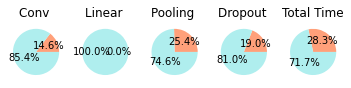

In [32]:
plot_layers_forward(results_vgg19)

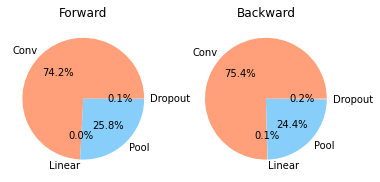

In [18]:
plot_results_time(results_Googlenet)

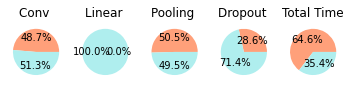

In [33]:
plot_layers_forward(results_Googlenet)

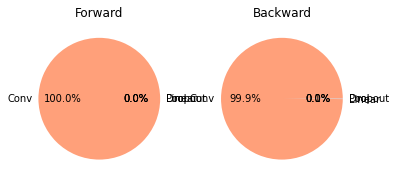

In [19]:
plot_results_time(results_mobilenet_v3_large)

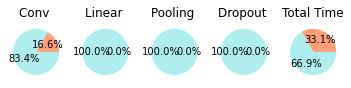

In [34]:
plot_layers_forward(results_mobilenet_v3_large)

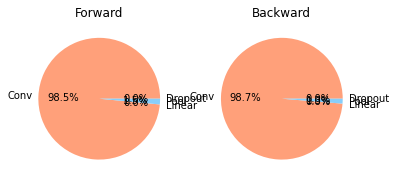

In [20]:
plot_results_time(results_Resnet50)

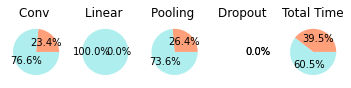

In [35]:
plot_layers_forward(results_Resnet50)

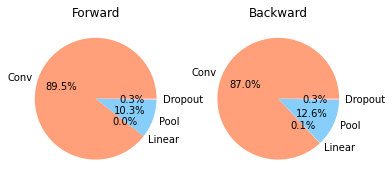

In [21]:
plot_results_time(results_AlexNet)

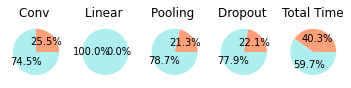

In [36]:
plot_layers_forward(results_AlexNet)

In [41]:
def plot_results_mem(results):
    """
    This function generates two sets of pie charts, one showing the breakdown of forward and backward time for 
    each layer type, and another showing the breakdown of total time for forward and backward passes. 
    
    Args:
    results (dict): Dictionary containing the results of a machine learning model's forward and backward passes.
    
    Returns:
    None
    """

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot pie chart for time breakdown of each layer type in forward pass
    ax1.pie([1000*results['forward_conv_mem'], 
             1000*results['forward_linear_mem'], 
             1000*results['forward_pool_mem'], 
             1000*results['forward_dropout_mem']], 
            labels=['Conv', 'Linear', 'Pool', 'Dropout'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE', '#87CEFA', '#FFC0CB']) # use colorblind friendly colors
    ax1.set_title('Forward')

    # Plot pie chart for time breakdown of each layer type in backward pass
    ax2.pie([1000*results['backward_conv_mem'], 
             1000*results['backward_linear_mem'], 
             1000*results['backward_pool_mem'], 
             1000*results['backward_dropout_mem']], 
            labels=['Conv', 'Linear', 'Pool', 'Dropout'], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE', '#87CEFA', '#FFC0CB']) # use colorblind friendly colors
    ax2.set_title('Backward')

    plt.show()


In [44]:
def plot_layers_backward(results):
  # Create figure with five subplots
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

    # Plot pie chart for time breakdown of conv layers in forward and backward passes
    ax1.pie([1000*results['forward_conv_mem'], 
             1000*results['backward_conv_mem']], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax1.set_title('Conv ')

    # Plot pie chart for time breakdown of linear layers in forward and backward passes
    ax2.pie([1000*results['forward_linear_mem'], 
             1000*results['backward_linear_mem']], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax2.set_title('Linear ')

    # Plot pie chart for time breakdown of pooling layers in forward and backward passes
    ax3.pie([1000*results['forward_pool_mem'], 
             1000*results['backward_pool_mem']],  
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax3.set_title('Pooling ')

    # Plot pie chart for time breakdown of dropout layers in forward and backward passes
    ax4.pie([1000*results['forward_dropout_mem'], 
             1000*results['backward_dropout_mem']], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax4.set_title('Dropout ')


    # Plot pie chart for time breakdown of total time in layers in forward and backward passes
    ax5.pie([1000*results['forward_total_mem'], 
             1000*results['backward_total_mem']], 
            autopct='%1.1f%%', 
            colors=['#FFA07A', '#AFEEEE']) # use colorblind friendly colors
    ax5.set_title('Total Memory ')

    plt.show()

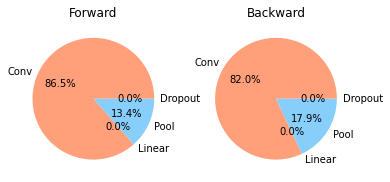

In [42]:
plot_results_mem(results_vgg19)

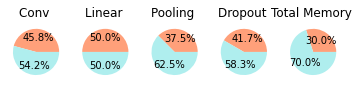

In [45]:
plot_layers_backward(results_vgg19)

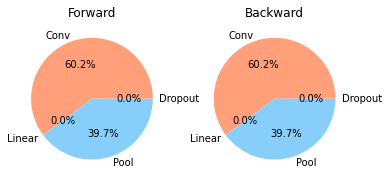

In [46]:
plot_results_mem(results_Googlenet)

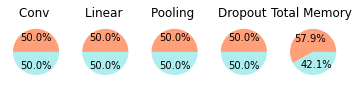

In [47]:
plot_layers_backward(results_Googlenet)

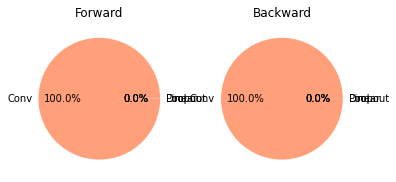

In [48]:
plot_results_mem(results_mobilenet_v3_large)

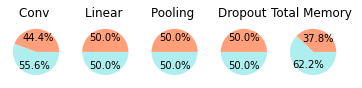

In [49]:
plot_layers_backward(results_mobilenet_v3_large)

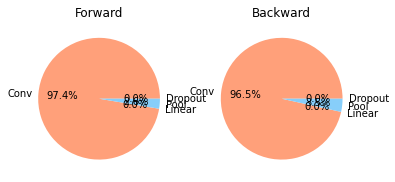

In [50]:
plot_results_mem(results_Resnet50)

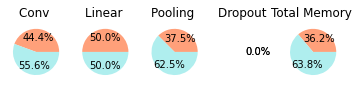

In [51]:
plot_layers_backward(results_Resnet50)

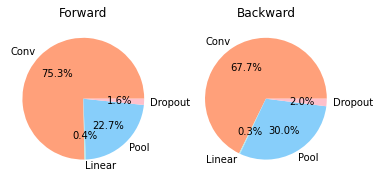

In [52]:
plot_results_mem(results_AlexNet)

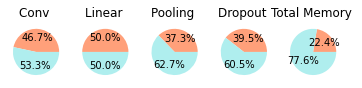

In [53]:
plot_layers_backward(results_AlexNet)

In [64]:
import torch
import time
from torch.profiler import profile, ProfilerActivity
from collections import defaultdict
import matplotlib.pyplot as plt

def ratios(model_name, model):
    # Move the model to CPU device
    device = torch.device('cpu')
    model = model.to(device)

    # Create random input tensors
    batch_t = torch.rand(size=(1, 3, 112, 112)).to(device)
    sample =  torch.rand(size=(1,1000)).to(device)

    # Run the model forward pass and calculate loss
    output = model(batch_t).to(device)
    loss = (sample - output).sum()

    # Profile the forward pass to get flops and time taken for each layer
    with profile(activities=[ProfilerActivity.CPU], with_flops=True, record_shapes=True) as fprof:
        start = time.time()
        model(batch_t)
        end = time.time()

    # Calculate total flops and flops for each layer
    flops = 0
    fwd = defaultdict(int)
    for event in fprof.events():
        if event.flops is not None and event.flops > 0:
            fwd[event.name] += event.flops
            flops += event.flops


    # Profile the backward pass to get flops and time taken for each layer
    with profile(activities=[ProfilerActivity.CPU], with_flops=True, record_shapes=True) as bprof:
        start2 = time.time()
        loss.backward()
        end2 = time.time()

    # Calculate total flops and flops for each layer
    bflops = 0
    bck = defaultdict(int)
    for event in bprof.events():
        if event.flops is not None and event.flops > 0:
            bck[event.name] += event.flops
            bflops += event.flops

    # Calculate and print the forward to backward ratio for latency and flops
    print("Ratio of latency and flops for", model_name, (end - start) / (end2 - start2), flops / bflops)


In [69]:
import torchvision.models as models

# Create an instance of a PyTorch model
model = models.resnet18()

# Call the ratios function with the model and model name
ratios('vgg19', model)

Ratio of latency and flops for vgg19 0.4100021277684557 425.3838905093112


In [65]:
import torchvision.models as models

# Create an instance of a PyTorch model
model = models.resnet18()

# Call the ratios function with the model and model name
ratios('Googlenet', model)

Ratio of latency and flops for Googlenet 0.5197159839397931 425.3838905093112


In [66]:
import torchvision.models as models

# Create an instance of a PyTorch model
model = models.resnet18()

# Call the ratios function with the model and model name
ratios('Mobilenet_v3_large', model)

Ratio of latency and flops for Mobilenet_v3_large 0.7302387027039694 425.3838905093112


In [67]:
import torchvision.models as models

# Create an instance of a PyTorch model
model = models.resnet18()

# Call the ratios function with the model and model name
ratios('ResNet50', model)

Ratio of latency and flops for ResNet50 0.5638096973512018 425.3838905093112


In [68]:
import torchvision.models as models

# Create an instance of a PyTorch model
model = models.resnet18()

# Call the ratios function with the model and model name
ratios('Alexnet', model)

Ratio of latency and flops for Alexnet 0.4782894531493851 425.3838905093112


In [76]:
import torch
import time
from torch.profiler import profile, ProfilerActivity
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_ratios(model_name, model):
    # Move the model to CPU device
    device = torch.device('cpu')
    model = model.to(device)

    # Create random input tensors
    batch_t = torch.rand(size=(1, 3, 112, 112)).to(device)
    sample =  torch.rand(size=(1,1000)).to(device)

    # Run the model forward pass and calculate loss
    output = model(batch_t).to(device)
    loss = (sample - output).sum()

    # Profile the forward pass to get flops and time taken for each layer
    with profile(activities=[ProfilerActivity.CPU], with_flops=True, record_shapes=True) as fprof:
        start = time.time()
        model(batch_t)
        end = time.time()

    # Calculate total flops and flops for each layer
    flops = 0
    fwd = defaultdict(int)
    for event in fprof.events():
        if event.flops is not None and event.flops > 0:
            fwd[event.name] += event.flops
            flops += event.flops

    # Plot a pie chart to show the flops breakdown for each layer in the forward pass
    labels = list(fwd.keys())
    sizes = list(fwd.values())
    plt.figure(dpi=120)
    plt.title('Layers for Forward Pass')
    plt.pie(sizes, labels=labels, colors=['#FFA07A', '#AFEEEE'])
    plt.axis('equal')
    plt.legend()
    plt.show()

    # Profile the backward pass to get flops and time taken for each layer
    with profile(activities=[ProfilerActivity.CPU], with_flops=True, record_shapes=True) as bprof:
        start2 = time.time()
        loss.backward()
        end2 = time.time()

    # Calculate total flops and flops for each layer
    bflops = 0
    bck = defaultdict(int)
    for event in bprof.events():
        if event.flops is not None and event.flops > 0:
            bck[event.name] += event.flops
            bflops += event.flops

    # Plot a pie chart to show the flops breakdown for each layer in the backward pass
    labels = list(bck.keys())
    sizes = list(bck.values())
    plt.figure(dpi=120)
    plt.title('Layers for Backward Pass')
    plt.pie(sizes, labels=labels, colors=['#FFA07A', '#AFEEEE'])
    plt.axis('equal')
    plt.legend()
    plt.show()



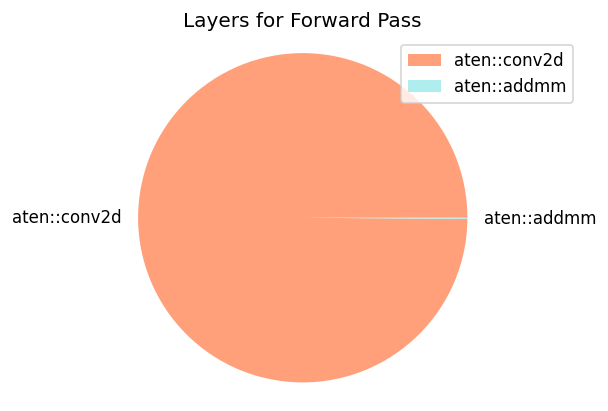

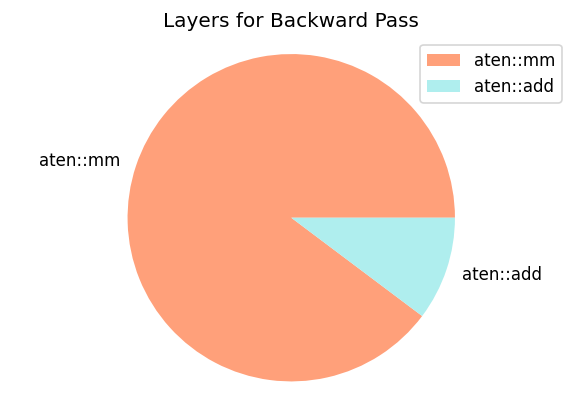

In [77]:
import torchvision.models as models

# Create an instance of a PyTorch model
model = models.resnet18()

# Call the ratios function with the model and model name
plot_ratios('GoogelNet', model)